# Decision Value

This Notebook contains all my code used for the creation of my Decision Value Model which quantifies the expected run value of a batter's swing decisions.

[For more information regarding my methodology, refer to my Medium Article](https://medium.com/@thomasjamesnestico/modelling-batter-decision-value-dac74c55e20a)

In [1]:
##Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from matplotlib import colors
from scipy.stats import zscore
import math
import matplotlib
from adjustText import adjust_text
import matplotlib.ticker as mtick

## Define Colour palette
colour_palette = ['#FFB000','#648FFF','#785EF0',
                  '#DC267F','#FE6100','#3D1EB2','#894D80','#16AA02','#B5592B','#A3C1ED']

## Define Strikezone
strike_zone = pd.DataFrame({
  'PlateLocSide': [-0.708, -0.708, 0.708, 0.708, -0.708],
  'PlateLocHeight': [1.5, 3.5, 3.5, 1.5, 1.5]
})

## Add strike zone to Plot
def draw_line(axis,alpha_spot=1,catcher_p = True):
    axis.plot(strike_zone['PlateLocSide'], strike_zone['PlateLocHeight'], color='black', linewidth=1.3,zorder=3,alpha=alpha_spot,)

import requests
teams =  requests.get(url='https://statsapi.mlb.com/api/v1/teams/').json()
#Select only teams that are at the MLB level
# mlb_teams_city = [x['franchiseName'] for x in teams['teams'] if x['sport']['name'] == 'Major League Baseball']
# mlb_teams_name = [x['teamName'] for x in teams['teams'] if x['sport']['name'] == 'Major League Baseball']
# mlb_teams_franchise = [x['name'] for x in teams['teams'] if x['sport']['name'] == 'Major League Baseball']
# mlb_teams_id = [x['id'] for x in teams['teams'] if x['sport']['name'] == 'Major League Baseball']
# mlb_teams_abb = [x['abbreviation'] for x in teams['teams'] if x['sport']['name'] == 'Major League Baseball']

mlb_teams_city = [x['franchiseName']  if 'franchiseName' in x else None for x in teams['teams']]
mlb_teams_name = [x['teamName']  if 'franchiseName' in x else None for x in teams['teams']]
mlb_teams_franchise = [x['name']  if 'franchiseName' in x else None for x in teams['teams']]
mlb_teams_id = [x['id']  if 'franchiseName' in x else None for x in teams['teams']]
mlb_teams_abb = [x['abbreviation']  if 'franchiseName' in x else None for x in teams['teams']]
mlb_teams_parent = [x['parentOrgName']  if 'parentOrgName' in x else None for x in teams['teams']]


#Create a dataframe of all the teams
mlb_teams_df = pd.DataFrame(data={'team_id':mlb_teams_id,'city':mlb_teams_franchise,'name':mlb_teams_name,'franchise':mlb_teams_franchise,'abbreviation':mlb_teams_abb,'parent_org':mlb_teams_parent}).drop_duplicates()
##Create a dataframe of all players in the database
#Make an api call to get a dictionary of all players
player_data = requests.get(url=f'https://statsapi.mlb.com/api/v1/sports/1/players').json()

#Select relevant data that will help distinguish players from one another
fullName_list = [x['fullName'] for x in player_data['people']]
id_list = [x['id'] for x in player_data['people']]
position_list = [x['primaryPosition']['abbreviation'] for x in player_data['people']]
team_list = [x['currentTeam']['id']for x in player_data['people']]
age_list = [x['currentAge']for x in player_data['people']]


mlb_teams_df = mlb_teams_df.merge(right=mlb_teams_df[['abbreviation','franchise']],left_on='parent_org',right_on='franchise',how='left').drop_duplicates().reset_index(drop=True)
mlb_teams_df = mlb_teams_df[mlb_teams_df.columns[:-1]]

mlb_teams_df.columns = ['team_id', 'city', 'name', 'franchise', 'abbreviation',
       'parent_org', 'parent_org_abb']
mlb_teams_df.parent_org_abb = mlb_teams_df.abbreviation

mlb_teams_df = mlb_teams_df.drop_duplicates(subset=['parent_org_abb','abbreviation'])

mlb_a_player_df = pd.DataFrame(data={'player_id':id_list,'batter':fullName_list,'position':position_list,'team_id':team_list,'age':age_list})
#Use the teams dataframe to merge the team name to the players dataframe
mlb_a_player_df = mlb_a_player_df.merge(right=mlb_teams_df[['team_id','franchise','parent_org_abb']],left_on='team_id',right_on='team_id',how='left',suffixes=['','_y'])
#make a column of the names all uppercase to make lookups easier
mlb_a_player_df['upper_name'] = mlb_a_player_df['batter'].str.upper()
#rename to make the data clearer
mlb_a_player_df = mlb_a_player_df.rename(columns={'franchise':'currentTeam'})

In [2]:
## Import Datasets 2020-22
df_2020 = pd.read_csv('2020_statcast_pybaseball_data.csv')
df_2021 = pd.read_csv('2021_statcast_pybaseball_data.csv')
df_2022 = pd.read_csv('2022_statcast_pybaseball_data.csv')

## Import Dataset 2023
df_2023 = pd.read_csv('2023_statcast_pybaseball_data.csv',index_col=[0])

In [3]:
## Define a dictionary to group outcomes together
des_dict = {'ball':'ball',
'hit_into_play':'hit_into_play',
'called_strike':'called_strike',
'foul':'foul',
'swinging_strike':'swinging_strike',
'blocked_ball':'ball',
'swinging_strike_blocked':'swinging_strike',
'foul_tip':'swinging_strike',
'foul_bunt':'foul',
'hit_by_pitch':'hit_by_pitch',
'pitchout':'ball',
'missed_bunt':'swinging_strike',
'bunt_foul_tip':'swinging_strike',
'foul_pitchout':'foul',}

## Define a dictionary to group events together
ev_dict = {'game_advisory':np.nan,
 'single':'single',
 'walk':'walk',
 np.nan:np.nan,
 'strikeout':'strikeout',
 'field_out':'field_out',
 'force_out':'field_out',
 'double':'double',
 'hit_by_pitch':'hit_by_pitch',
 'home_run':'home_run',
 'grounded_into_double_play':'field_out',
 'fielders_choice_out':'field_out',
 'fielders_choice':'field_out',
 'field_error':np.nan,
 'double_play':'field_out',
 'sac_fly':'field_out',
 'strikeout_double_play':np.nan,
 'triple':'triple',
 'caught_stealing_2b':np.nan,
 'sac_bunt':'field_out',
 'catcher_interf':np.nan,
 'caught_stealing_3b':np.nan,
 'sac_fly_double_play':'field_out',
 'triple_play':'field_out',
 'other_out':'field_out',
 'pickoff_3b':np.nan,
 'caught_stealing_home':np.nan,
 'pickoff_1b':np.nan,
 'pickoff_2b':np.nan,
 'wild_pitch':'wild_pitch',
 'stolen_base_2b':np.nan,
 'pickoff_caught_stealing_3b':np.nan,
 'pickoff_caught_stealing_2b':np.nan,
 'sac_bunt_double_play':np.nan,
 'passed_ball':np.nan,
 'pickoff_caught_stealing_home':np.nan,}

In [4]:
## Concatenate 2020-22 Dataset for Training
df_model = pd.concat([df_2020,df_2021,df_2022]).reset_index(drop=True)

In [5]:
## Define lists which contain Swing Outcomes
swing_in = ['foul_bunt','foul','hit_into_play','swinging_strike', 'foul_tip', 'swinging_strike_blocked','missed_bunt','bunt_foul_tip']


In [6]:
## Define a function which applies relevant transformations
def df_clean(df):
    # Create a new column with the grouped decisions
    df['des_new'] = df.description.map(des_dict)
    # Create a new column with the grouped events
    df['ev_new'] = df.loc[df['des_new'] == 'hit_into_play','events'].map(ev_dict)
    df.loc[df['des_new']=='hit_into_play','des_new'] = df.loc[df['des_new']=='hit_into_play','ev_new']
    df = df.dropna(subset=['des_new'])
    # Create a dataset with average run expectancy 
    # given outcome and count
    des_values = df.groupby(['des_new','strikes','balls'])['delta_run_exp'].mean()
    # Merge the average run expectancies to the dataset
    df = df.merge(des_values,left_on=['des_new','strikes','balls'],right_on=['des_new','strikes','balls'],suffixes=['','_mean'])
    # Add a binary columns for swings
    conditions_swings = [(df['description'].isin(swing_in))]
    choices_swings = [True]
    df['swing'] = np.select(conditions_swings, choices_swings, default=0)
    return df

## Transform the Datasets
df_model = df_clean(df=df_model).dropna(subset=['pitch_type'])
df_model_2023 = df_clean(df=df_2023).dropna(subset=['pitch_type'])

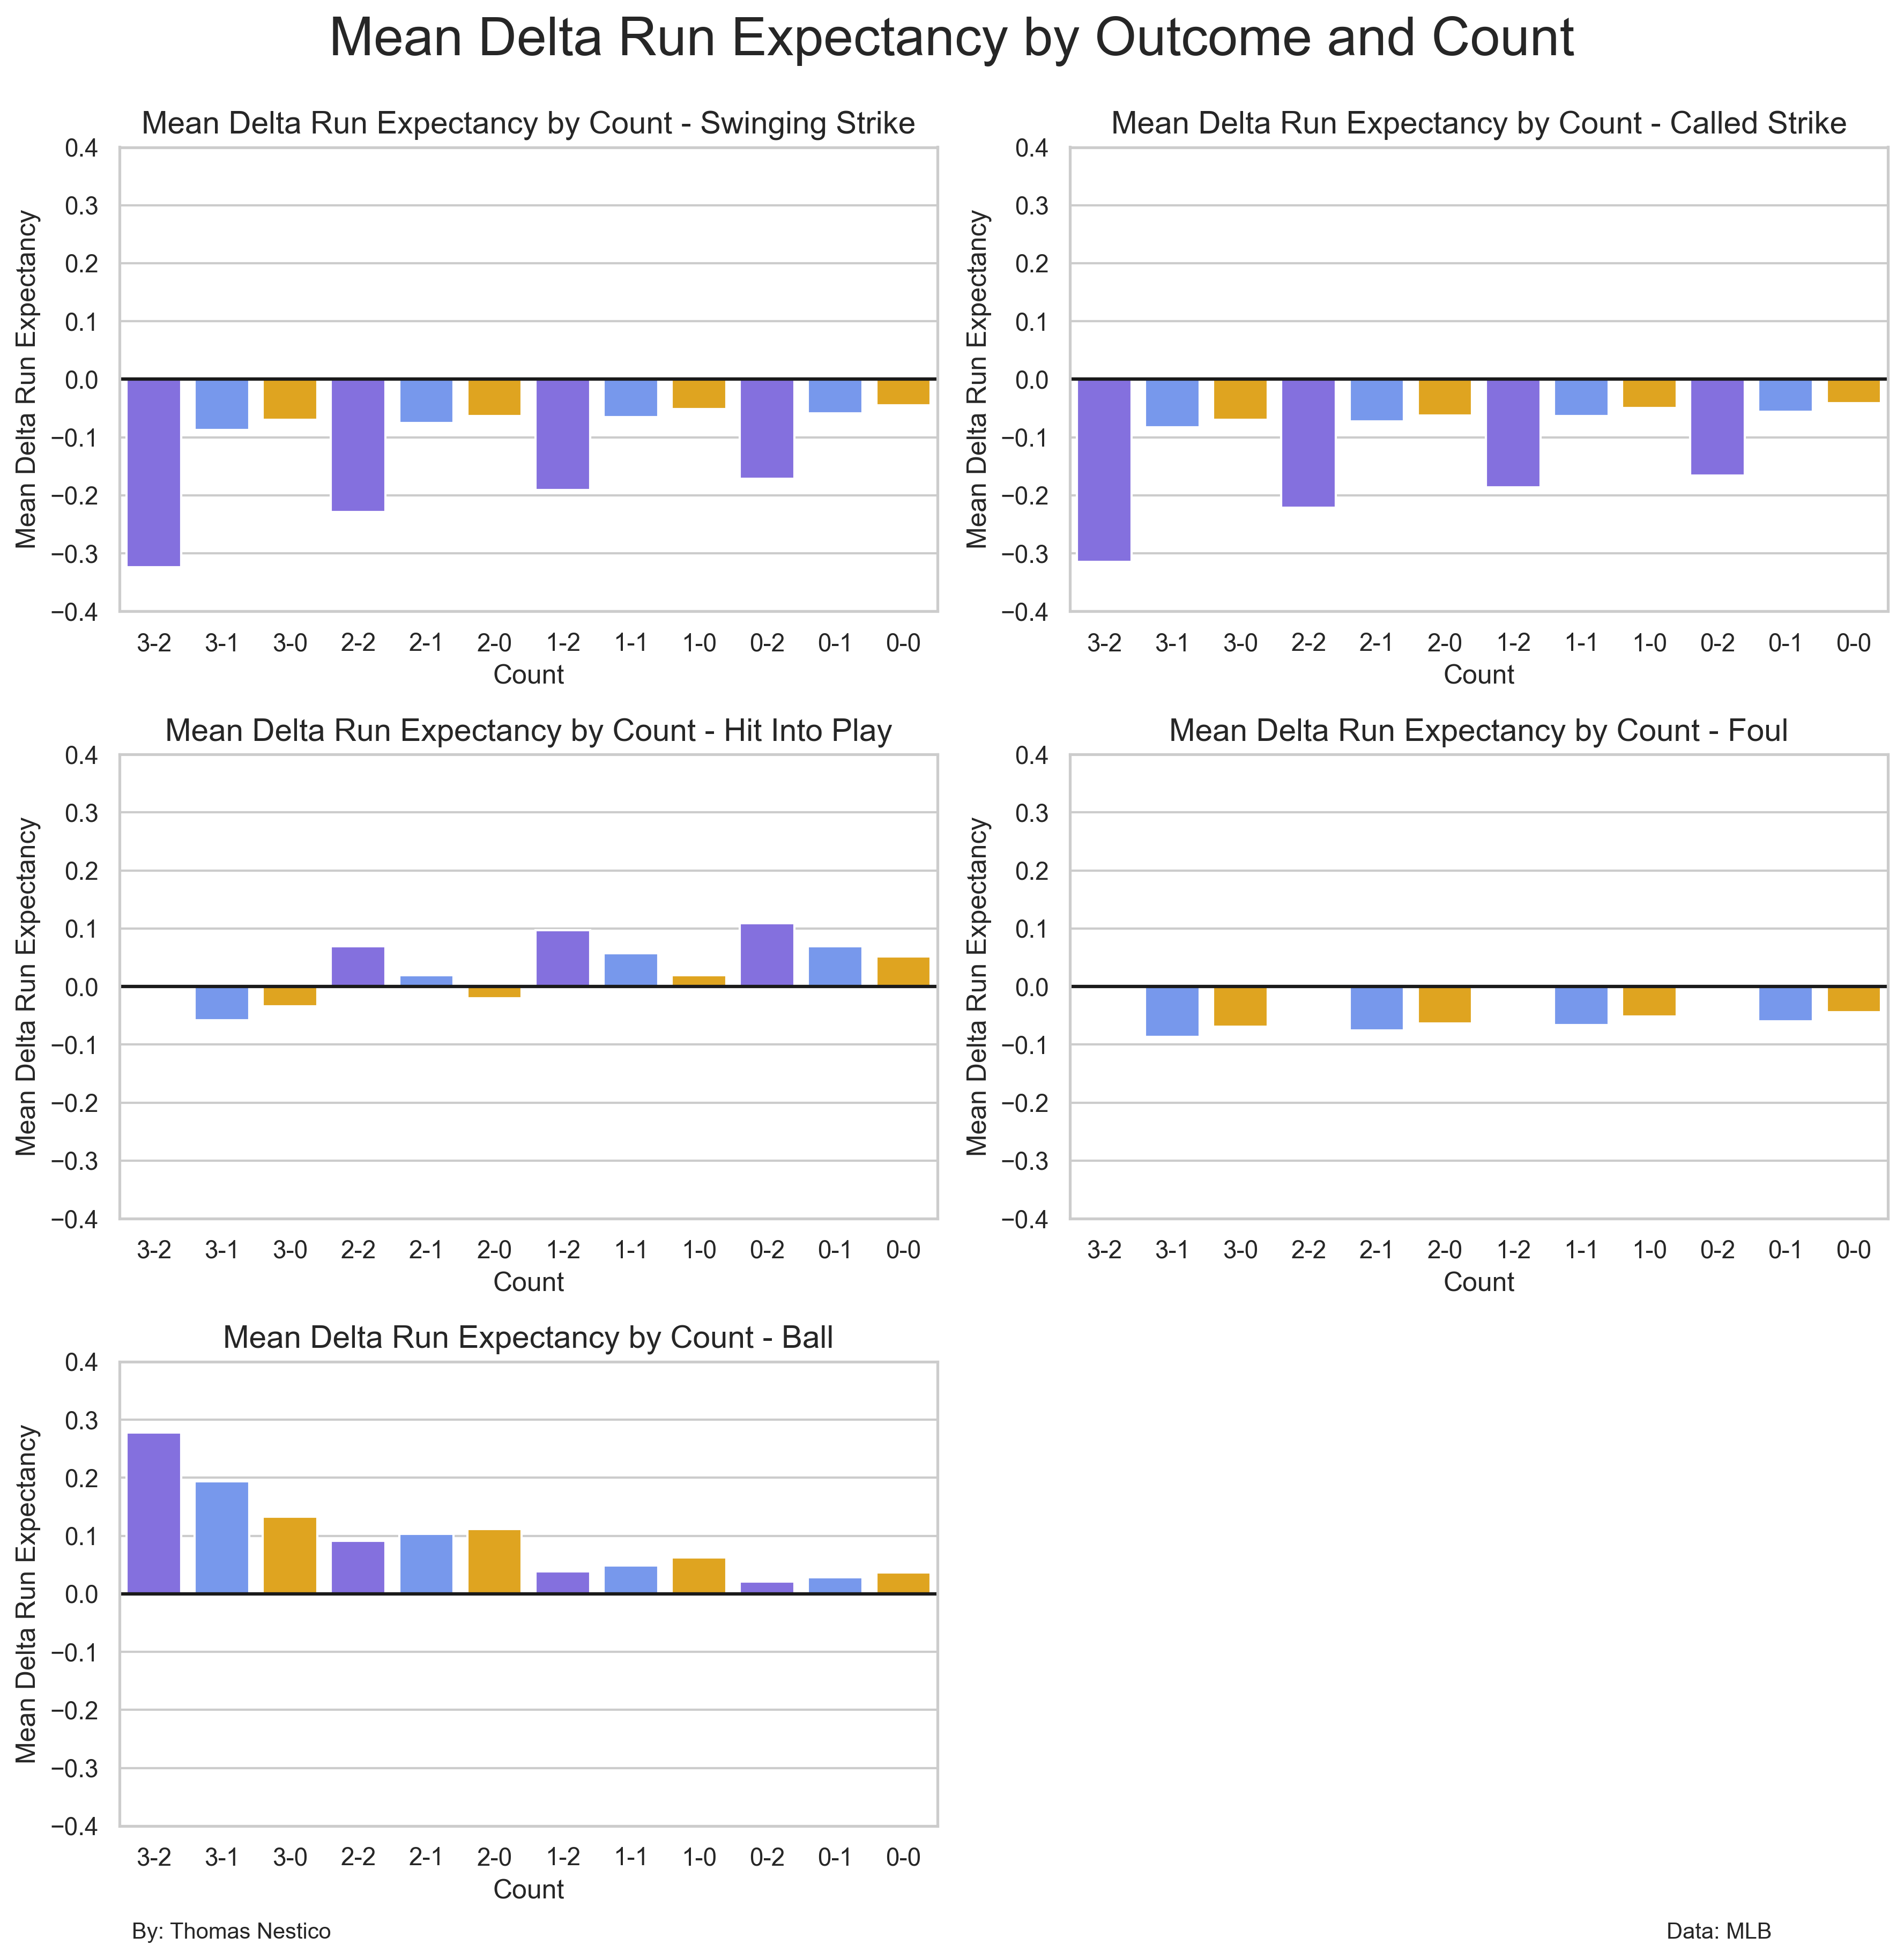

In [7]:
## Create Dataframe to plot Run Expectancies for Outcomes
outcomes_delta = ['swinging_strike', 'called_strike', 'foul','hit_into_play', 'ball']
outcomes_df = df_model.groupby(['description','strikes','balls'])['delta_run_exp_mean'].mean().sort_values().reset_index()
outcomes_df = outcomes_df[outcomes_df.description.isin(outcomes_delta)]
outcomes_df = outcomes_df[(outcomes_df.strikes<=2)&(outcomes_df.balls<=3)]
outcomes_df['count'] = outcomes_df.balls.astype(str) + '-' + outcomes_df.strikes.astype(str)
outcomes_df = outcomes_df.sort_values(['balls','strikes'],ascending=False)

outcome_titles = {'swinging_strike':'Swinging Strike',
'called_strike':'Called Strike',
'foul':'Foul',
'hit_into_play':'Hit Into Play',
'ball':'Ball'}

sns.set_theme(style="whitegrid", palette="pastel")

fig, ax = plt.subplots(3, 2, figsize=(12, 12),dpi=300)

axs = [item for sublist in ax for item in sublist]
axs[5].axis('off')
for outx in range(0,len(outcomes_df.description.unique())):
    
    sns.barplot(data=outcomes_df[outcomes_df.description==outcomes_df.description.unique()[outx]],
                y='delta_run_exp_mean',x='count',palette=colour_palette[2::-1],ax=axs[outx])

    axs[outx].set_ylim(-0.4,0.4)
    axs[outx].hlines(y=0,xmin=-0.5,xmax=11.5,color='k')
    axs[outx].set_xlim(-0.5,11.5)

    axs[outx].set_xlabel('Count')
    axs[outx].set_ylabel('Mean Delta Run Expectancy')
    axs[outx].set_title(f'Mean Delta Run Expectancy by Count - {outcome_titles[outcomes_df.description.unique()[outx]]}',fontsize=14)

fig.suptitle(x=0.5, y=0.98, t="Mean Delta Run Expectancy by Outcome and Count",ha='center', va='center',fontsize=24)
fig.text(0.075, 0.00, "By: Thomas Nestico",ha='left', va='center',fontsize=10)
fig.text(0.925, 0.00, "Data: MLB",ha='right', va='center',fontsize=10)
fig.set_facecolor('white')
fig.tight_layout()

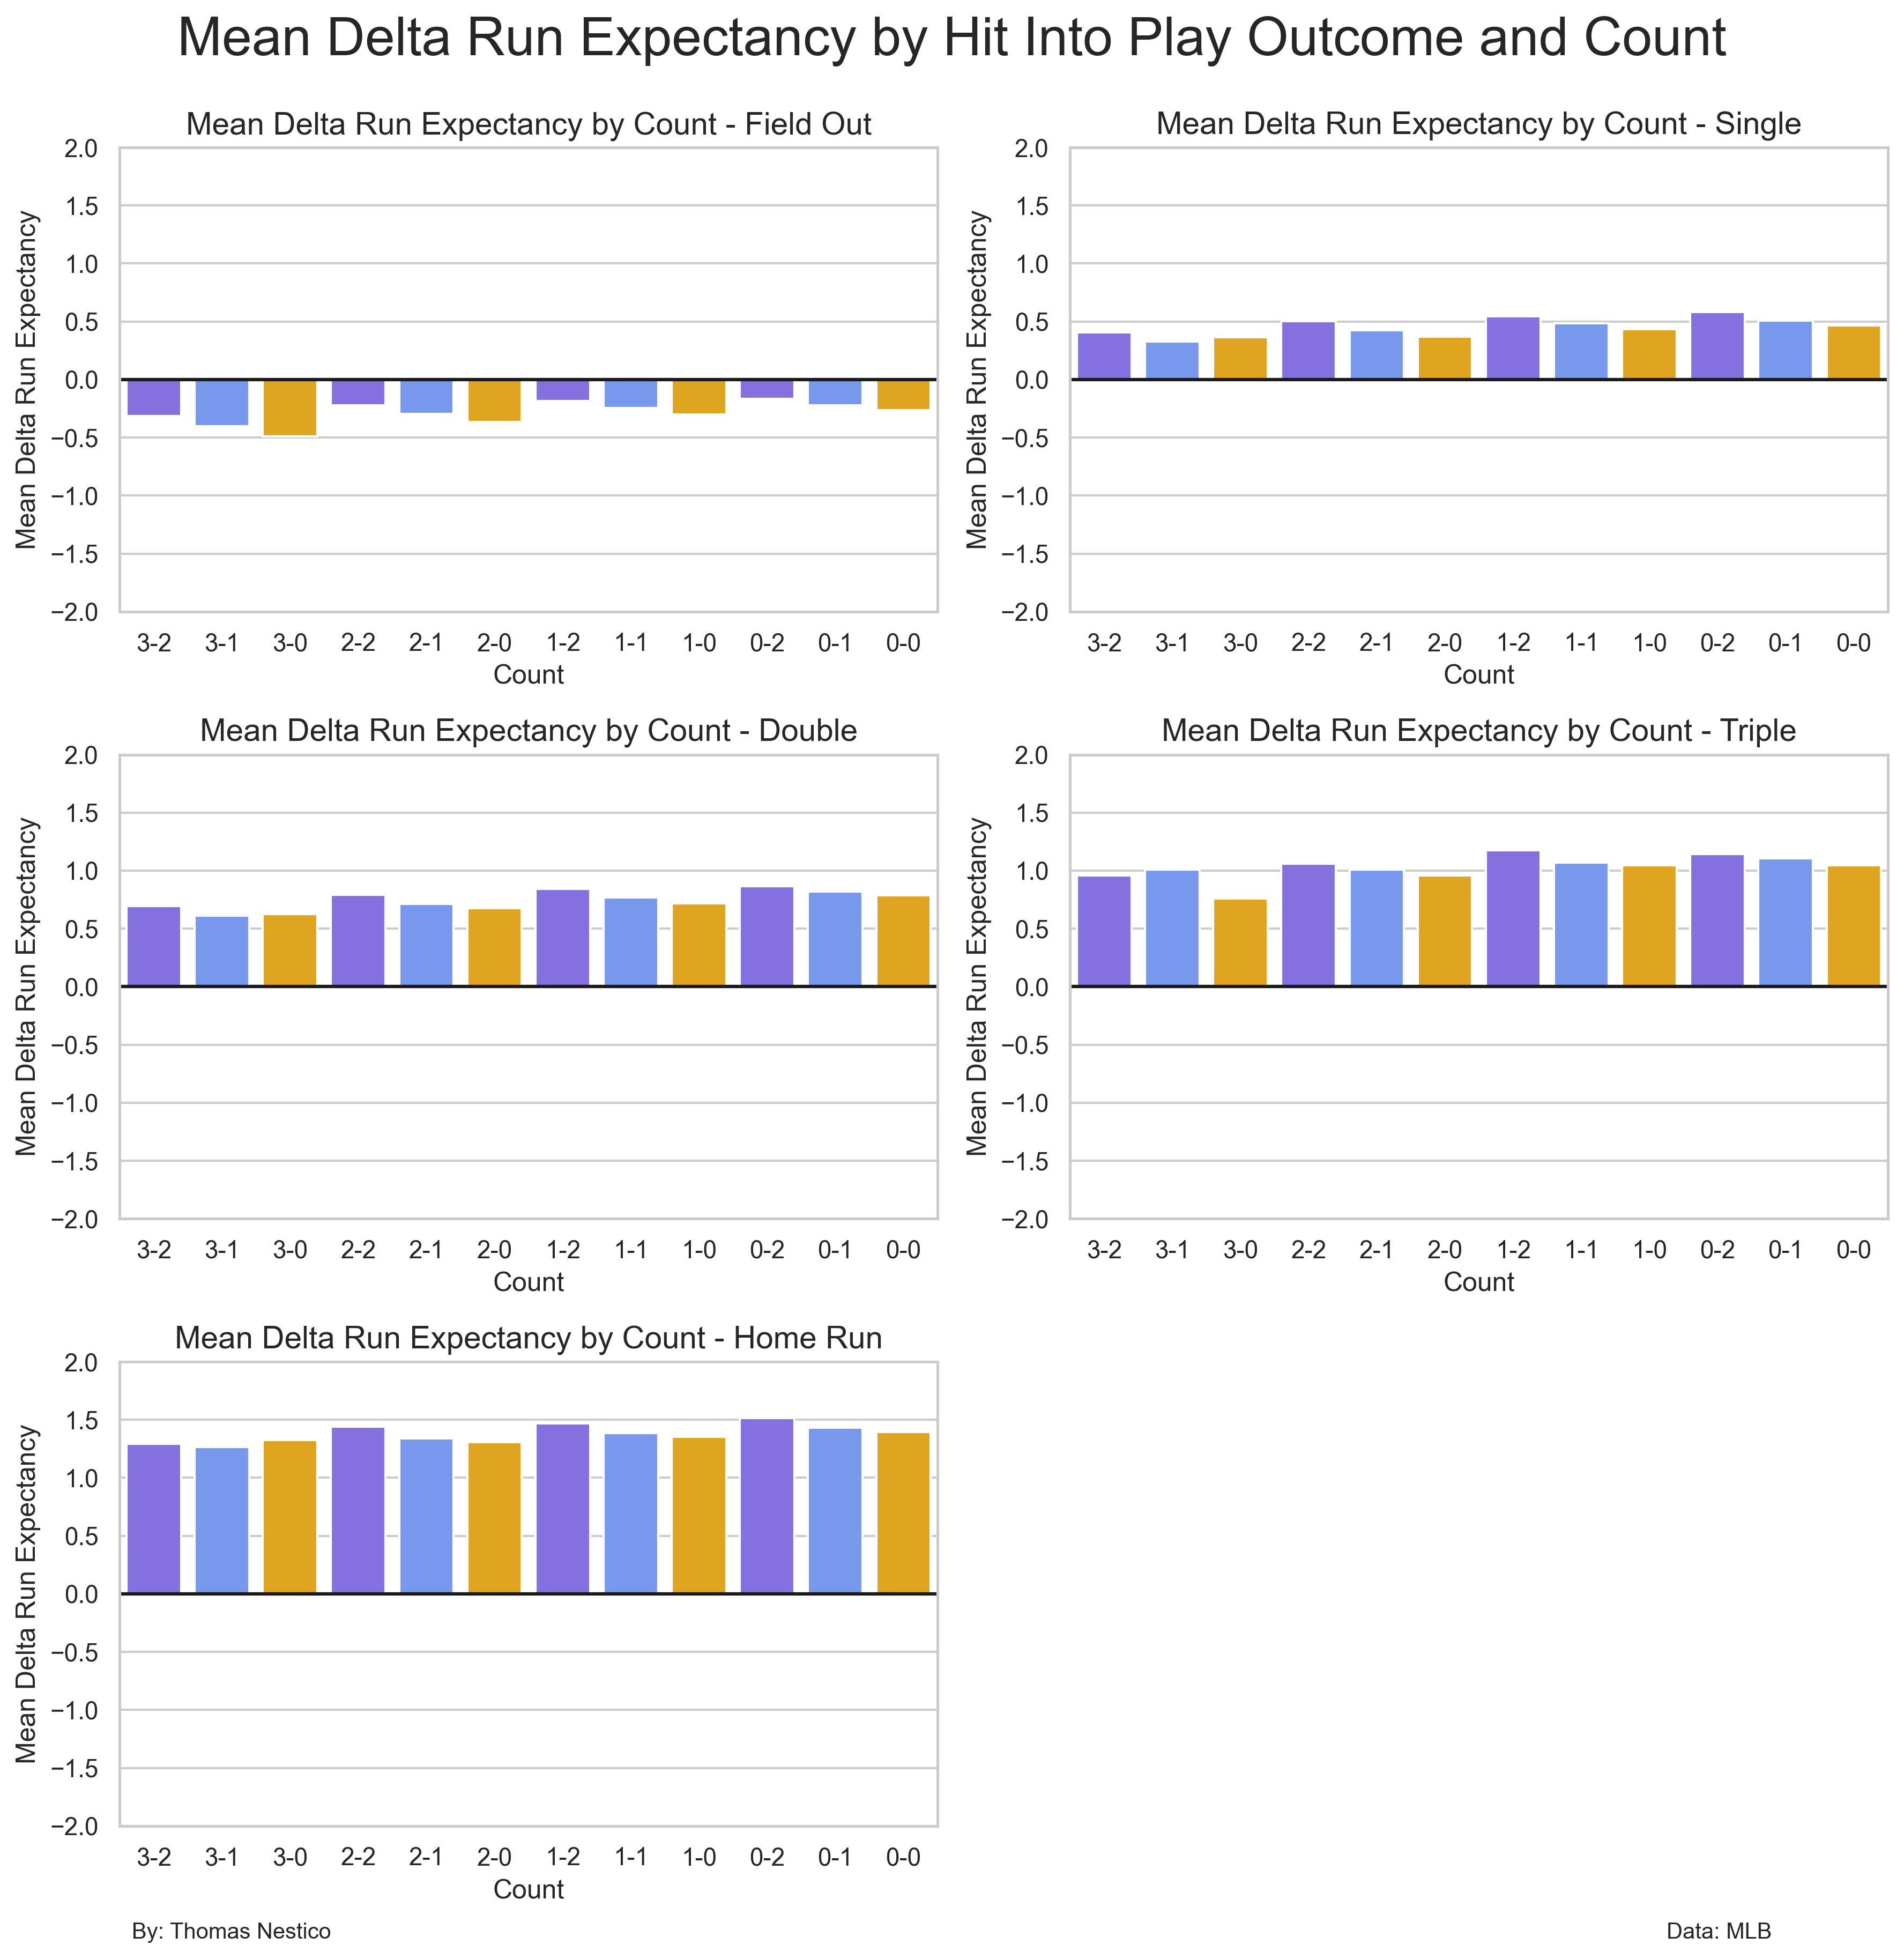

In [8]:
## Create Dataframe to plot Run Expectancies for Hits into Play
outcomes_df_hit = df_model[df_model.description == 'hit_into_play'].groupby(['ev_new','strikes','balls'])['delta_run_exp_mean'].mean().sort_values().reset_index()
outcomes_df_hit = outcomes_df_hit[outcomes_df_hit.ev_new.isin(df_model[df_model.description == 'hit_into_play'].ev_new.unique())]
outcomes_df_hit = outcomes_df_hit[(outcomes_df_hit.strikes<=2)&(outcomes_df_hit.balls<=3)]
outcomes_df_hit['count'] = outcomes_df_hit.balls.astype(str) + '-' + outcomes_df_hit.strikes.astype(str)
outcomes_df_hit = outcomes_df_hit.sort_values(['balls','strikes'],ascending=False)


outcome_titles_hit = {'single':'Single',
'field_out':'Field Out',
'double':'Double',
'home_run':'Home Run',
'triple':'Triple'}


sns.set_theme(style="whitegrid", palette="pastel")

fig, ax = plt.subplots(3, 2, figsize=(12, 12),dpi=300)

axs = [item for sublist in ax for item in sublist]
axs[5].axis('off')
for outx in range(0,len(outcomes_df_hit.ev_new.unique())):
    
    sns.barplot(data=outcomes_df_hit[outcomes_df_hit.ev_new==outcomes_df_hit.ev_new.unique()[outx]],
                y='delta_run_exp_mean',x='count',palette=colour_palette[2::-1],ax=axs[outx])

    axs[outx].set_ylim(-2,2)
    axs[outx].hlines(y=0,xmin=-0.5,xmax=11.5,color='k')
    axs[outx].set_xlim(-0.5,11.5)

    axs[outx].set_xlabel('Count')
    axs[outx].set_ylabel('Mean Delta Run Expectancy')
    axs[outx].set_title(f'Mean Delta Run Expectancy by Count - {outcome_titles_hit[outcomes_df_hit.ev_new.unique()[outx]]}',fontsize=14)

fig.suptitle(x=0.5, y=0.98, t="Mean Delta Run Expectancy by Hit Into Play Outcome and Count",ha='center', va='center',fontsize=24)
fig.text(0.075, 0.00, "By: Thomas Nestico",ha='left', va='center',fontsize=10)
fig.text(0.925, 0.00, "Data: MLB",ha='right', va='center',fontsize=10)
fig.set_facecolor('white')
fig.tight_layout()

<ipython-input-9-eca617973374>:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar_big = fig.colorbar(sm, cax=cbar_ax,aspect=30,shrink=0.7)
posx and posy should be finite values


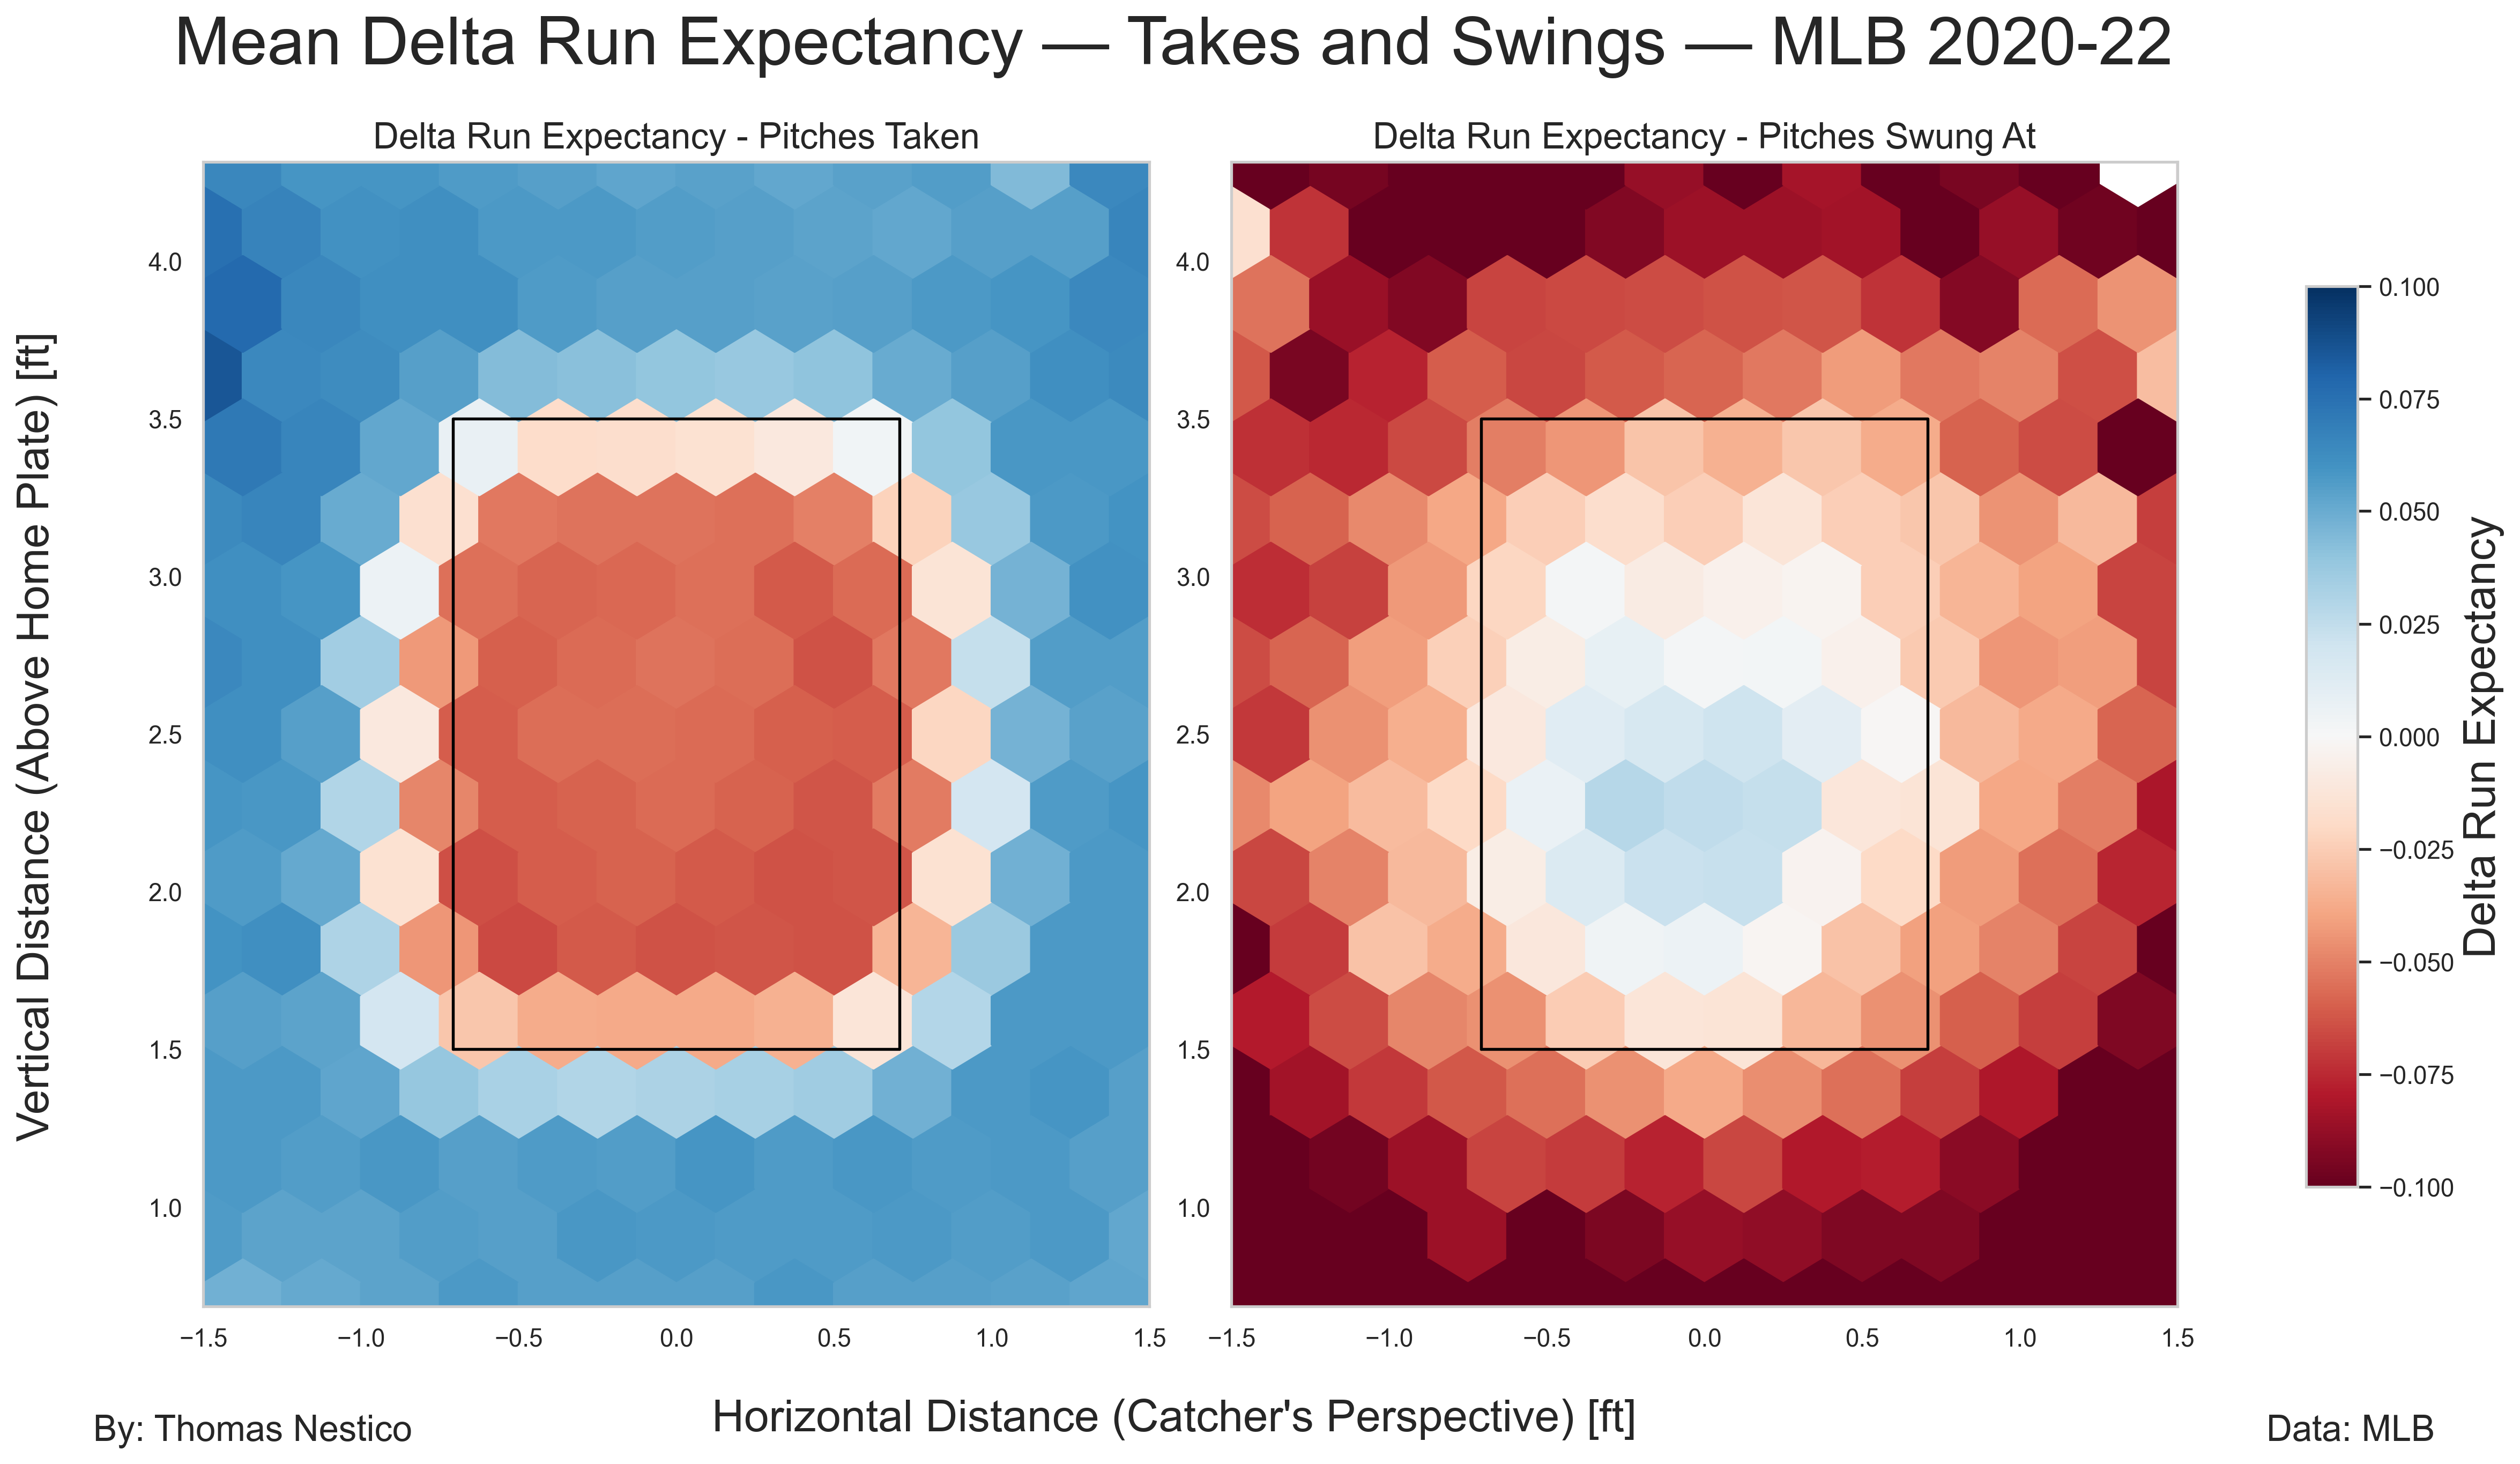

In [9]:
## 2020-22 Mean Delta Run Expectancy Hexbin Plot
x_min = -2.5
x_max = 2.5
y_min = 0
y_max = 5
extent = [x_min, x_max, y_min, y_max]

# define your scale, with white at zero
vmin = -0.1
vmax = 0.1

#for p_th in range(0,2):
sns.set_theme(style="whitegrid", palette="pastel")
fig, ax = plt.subplots(1, 2, figsize=(16, 8),dpi=300)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=np.array([vmin,vmax]).mean(), vmax=vmax)
#norm = plt.Normalize(vmin,vmax)
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)


ax[0].hexbin(
            x=df_model_2023[(df_model_2023.swing == 0)]['plate_x'],
            y=df_model_2023[(df_model_2023.swing == 0)]['plate_z'],
            C=df_model_2023[(df_model_2023.swing == 0)]['delta_run_exp_mean'],
                    cmap='RdBu',
                    norm=norm,extent=extent,gridsize=20)


ax[1].hexbin(
            x=df_model_2023[(df_model_2023.swing == 1)]['plate_x'],
            y=df_model_2023[(df_model_2023.swing == 1)]['plate_z'],
            C=df_model_2023[(df_model_2023.swing == 1)]['delta_run_exp_mean'],
                    cmap='RdBu',
                    norm=norm,extent=extent,gridsize=20)
ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_xlim(-1.5,1.5)
ax[1].set_xlim(-1.5,1.5)

draw_line(ax[0],catcher_p=False)
draw_line(ax[1],catcher_p=False)

ax[0].set_ylim(1,4)
ax[1].set_ylim(1,4)

ax[0].set_title('Delta Run Expectancy - Pitches Taken',fontsize=16)
ax[1].set_title('Delta Run Expectancy - Pitches Swung At',fontsize=16)
fig.tight_layout()



cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar_big = fig.colorbar(sm, cax=cbar_ax,aspect=30,shrink=0.7)
cbar_big.set_label('Delta Run Expectancy',fontsize=20)

fig.subplots_adjust(right=0.8)

fig.suptitle(x=0.41,y=1.06,t=f"Mean Delta Run Expectancy — Takes and Swings — MLB 2020-22",fontsize=30)
fig.text(0.41, -0.04, "Horizontal Distance (Catcher's Perspective) [ft]", ha='center',fontsize=20)
fig.text(-0.04, 0.5, "Vertical Distance (Above Home Plate) [ft]", va='center', rotation='vertical',fontsize=20)

fig.text(-0.01, -0.04, "By: Thomas Nestico",ha='left', va='center',fontsize=16)
fig.text(0.9, -0.04, "Data: MLB",ha='right', va='center',fontsize=16)
fig.set_facecolor('white')

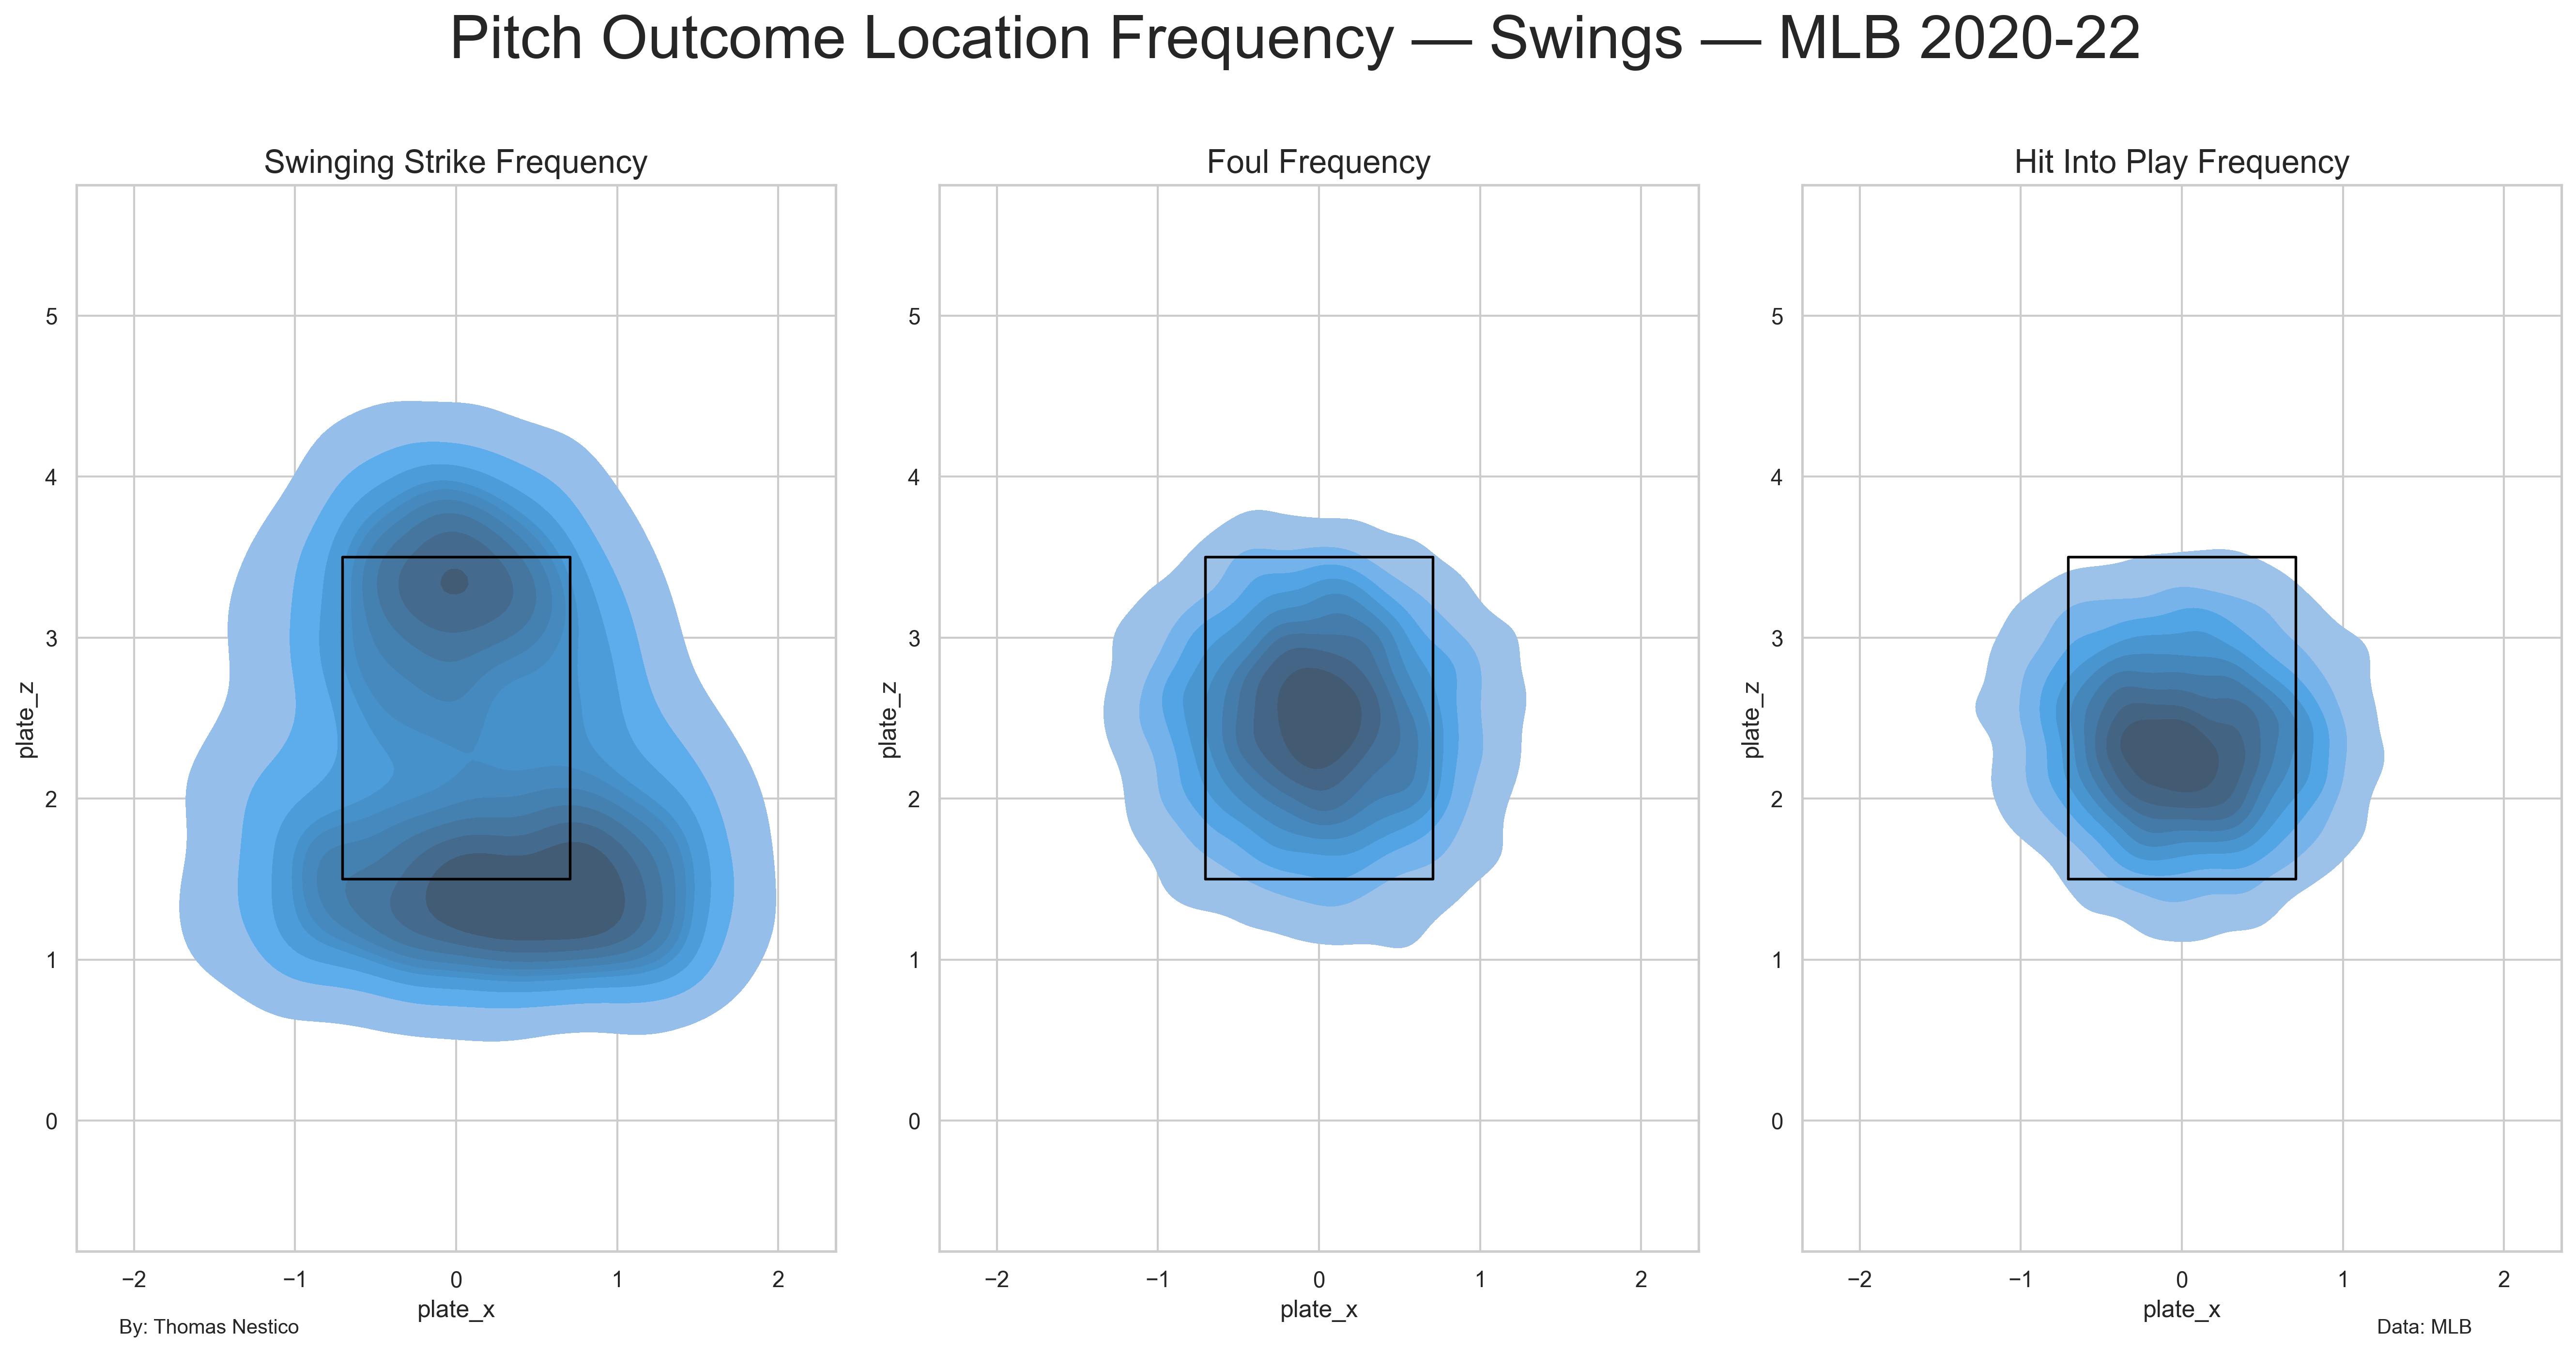

In [10]:
fig, ax = plt.subplots(1,3,figsize=(18,9),dpi=300)

sns.kdeplot(
    data=df_model[(df_model.description == 'swinging_strike')&(df_model.swing==1)].head(5000),
    x='plate_x',
    y='plate_z',
    fill=True,
    ax=ax[0]
)

sns.kdeplot(
    data=df_model[(df_model.description == 'foul')&(df_model.swing==1)].head(5000),
    x='plate_x',
    y='plate_z',
    fill=True,
    ax=ax[1]
)

sns.kdeplot(
    data=df_model[(df_model.description == 'hit_into_play')&(df_model.swing==1)].head(5000),
    x='plate_x',
    y='plate_z',
    fill=True,
    ax=ax[2]
)

ax[0].axis('equal')
ax[1].axis('equal')
ax[2].axis('equal')
ax[0].set_xlim(-2,2)
ax[1].set_xlim(-2,2)
ax[2].set_xlim(-2,2)

draw_line(ax[0],catcher_p=False)
draw_line(ax[1],catcher_p=False)
draw_line(ax[2],catcher_p=False)


ax[0].set_ylim(0.5,4.5)
ax[1].set_ylim(0.5,4.5)
ax[2].set_ylim(0.5,4.5)

ax[0].set_title('Swinging Strike Frequency',fontsize=16)
ax[1].set_title('Foul Frequency',fontsize=16)
ax[2].set_title('Hit Into Play Frequency',fontsize=16)

fig.suptitle(x=0.5,y=1.02,t=f"Pitch Outcome Location Frequency — Swings — MLB 2020-22",fontsize=30)


fig.text(0.05, 0.015, "By: Thomas Nestico",ha='left', va='center',fontsize=10)
fig.text(0.95, 0.015, "Data: MLB",ha='right', va='center',fontsize=10)
fig.tight_layout()


In [11]:
## Define Features and Target
features = ['plate_x','plate_z','strikes','balls']
targets = ['delta_run_exp_mean']

## Set up 2 Datasets: 1) Takes, 2) Swings
df_model_no_swing = df_model[df_model.swing != 1].dropna(subset=features+targets)
df_model_swing = df_model[df_model.swing == 1].dropna(subset=features+targets)


Mean Squared Error: 0.044927881107701094
Feature Importance:
plate_z: 1052.0
plate_x: 1045.0
balls: 557.0
strikes: 338.0


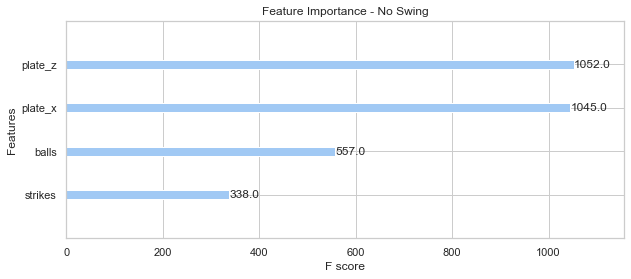

In [12]:
## Train XGBoost Decision Tree for No Swing Model
X = df_model_no_swing[features]
y = df_model_no_swing[targets].values[:,0]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format, which is a data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 5,  # Maximum depth of the tree
    'learning_rate': 0.1,  # Step size shrinkage
    'eval_metric': 'rmse'  # Evaluation metric: root mean squared error
}

# Train the XGBoost model_no_swing
num_rounds = 100  # Number of boosting rounds
model_no_swing = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred_no_swing = model_no_swing.predict(dtest)

# Evaluate the model_no_swing
rmse_no_swing = math.sqrt(mean_squared_error(y_test, y_pred_no_swing))
print(f'Mean Squared Error: {rmse_no_swing}')

## Plot Importance Factors
fig, ax = plt.subplots(figsize=(10,4))

# Get feature importance scores
feature_importance = model_no_swing.get_score(importance_type='weight')

# Sort the feature importance scores
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print feature importance
print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

# Plot feature importance
xgb.plot_importance(model_no_swing, ax =ax)
ax.set_title('Feature Importance - No Swing')
plt.show()


Mean Squared Error: 0.2945206145091249
Feature Importance:
plate_z: 1223.0
plate_x: 1143.0
strikes: 369.0
balls: 278.0


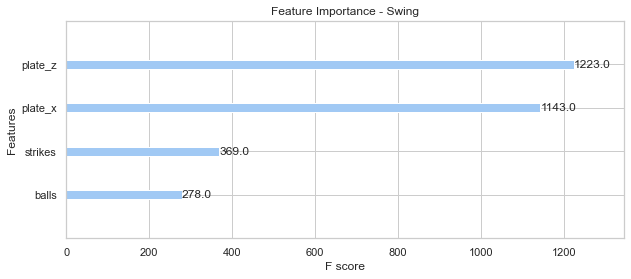

In [13]:
## Train XGBoost Decision Tree for Swing Model
X = df_model_swing[features]
y = df_model_swing[targets].values[:,0]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format, which is a data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 5,  # Maximum depth of the tree
    'learning_rate': 0.1,  # Step size shrinkage
    'eval_metric': 'rmse'  # Evaluation metric: root mean squared error
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model_swing = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = model_swing.predict(dtest)

# Evaluate the model
rmse_swing = math.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Squared Error: {rmse_swing}')

## Plot Importance Factors
fig, ax = plt.subplots(figsize=(10,4))
# Get feature importance scores
feature_importance = model_swing.get_score(importance_type='weight')

# Sort the feature importance scores
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print feature importance
print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

# Plot feature importance
xgb.plot_importance(model_swing,ax=ax)
ax.set_title('Feature Importance - Swing')
plt.show()

plt.show()


In [14]:
## Set up 2023 Data for Prediction of Run Expectancy
df_model_2023_no_swing = df_model_2023[df_model_2023.swing != 1].dropna(subset=features+targets)
df_model_2023_swing = df_model_2023[df_model_2023.swing == 1].dropna(subset=features+targets)

## Make Predictions
df_model_2023_no_swing['y_pred'] = model_no_swing.predict(xgb.DMatrix(df_model_2023_no_swing[features]))
df_model_2023_swing['y_pred'] = model_swing.predict(xgb.DMatrix(df_model_2023_swing[features]))

## Create df with Predictions
df_model_2023 = pd.concat([df_model_2023_no_swing,df_model_2023_swing])

## Create a dictionary of MLB Pitchers and Teams in 2023 
player_df = mlb_a_player_df[mlb_a_player_df.player_id.isin(df_model_2023.pitcher.unique())].reset_index(drop=True)
pitcher_dict = player_df.set_index('player_id')['batter'].to_dict()
team_player_dict = mlb_a_player_df.set_index('player_id')['parent_org_abb'].to_dict()


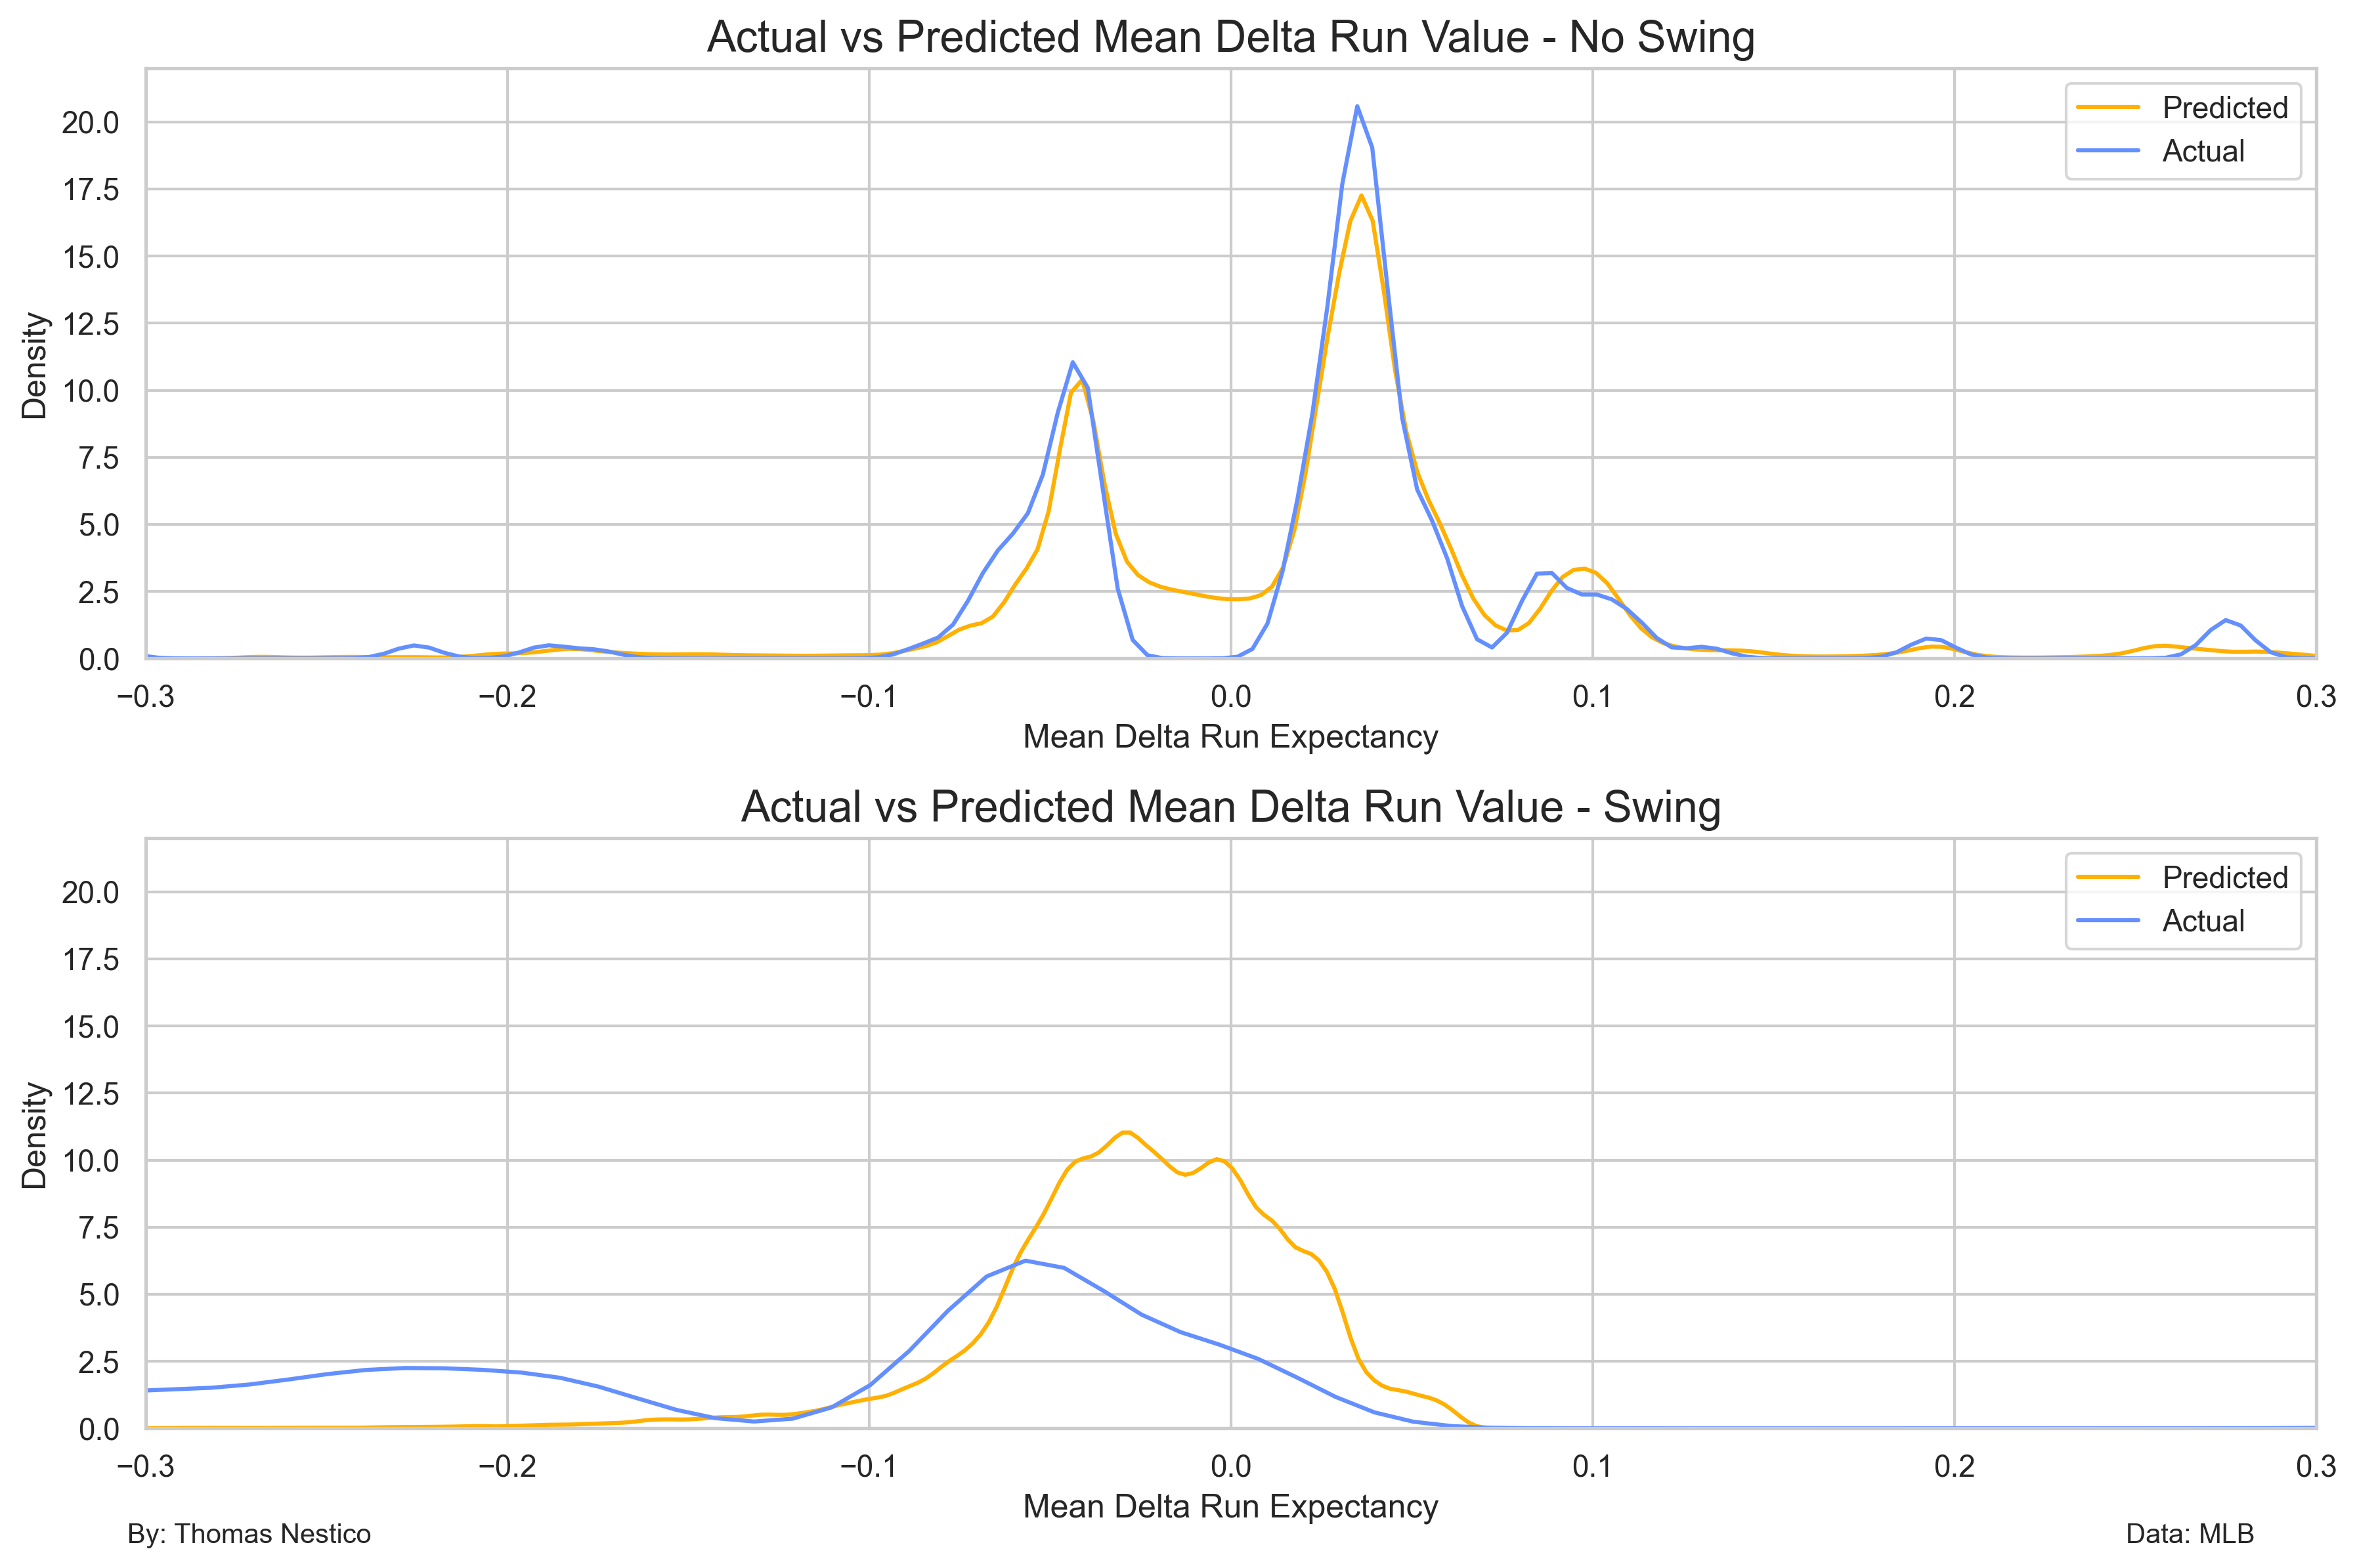

In [15]:
## Plot Actual vs Predicted Run Expectancies
fig, ax = plt.subplots(2, 1, figsize=(12, 8),dpi=300)

sns.kdeplot(data=df_model_2023[df_model_2023.swing==0],x='y_pred',ax=ax[0],color=colour_palette[0],label='Predicted')
sns.kdeplot(data=df_model_2023[df_model_2023.swing==0],x='delta_run_exp_mean',ax=ax[0],color=colour_palette[1],label='Actual')

sns.kdeplot(data=df_model_2023[df_model_2023.swing==1],x='y_pred',ax=ax[1],color=colour_palette[0],label='Predicted')
sns.kdeplot(data=df_model_2023[df_model_2023.swing==1],x='delta_run_exp_mean',ax=ax[1],color=colour_palette[1],label='Actual')

ax[0].set_title('Actual vs Predicted Mean Delta Run Value - No Swing',fontsize=16)
ax[1].set_title('Actual vs Predicted Mean Delta Run Value - Swing',fontsize=16)

ax[0].set_xlabel('Mean Delta Run Expectancy')
ax[1].set_xlabel('Mean Delta Run Expectancy')

ax[0].legend()
ax[1].legend()
ax[0].set_xlim(-0.3,0.3)
ax[1].set_xlim(-0.3,0.3)
ax[0].set_ylim(0,22)
ax[1].set_ylim(0,22)

fig.text(0.05, 0.015, "By: Thomas Nestico",ha='left', va='center',fontsize=10)
fig.text(0.95, 0.015, "Data: MLB",ha='right', va='center',fontsize=10)

fig.tight_layout()

<ipython-input-16-24f203563e8f>:73: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar_big = fig.colorbar(sm, cax=cbar_ax,aspect=30,shrink=0.7)
posx and posy should be finite values


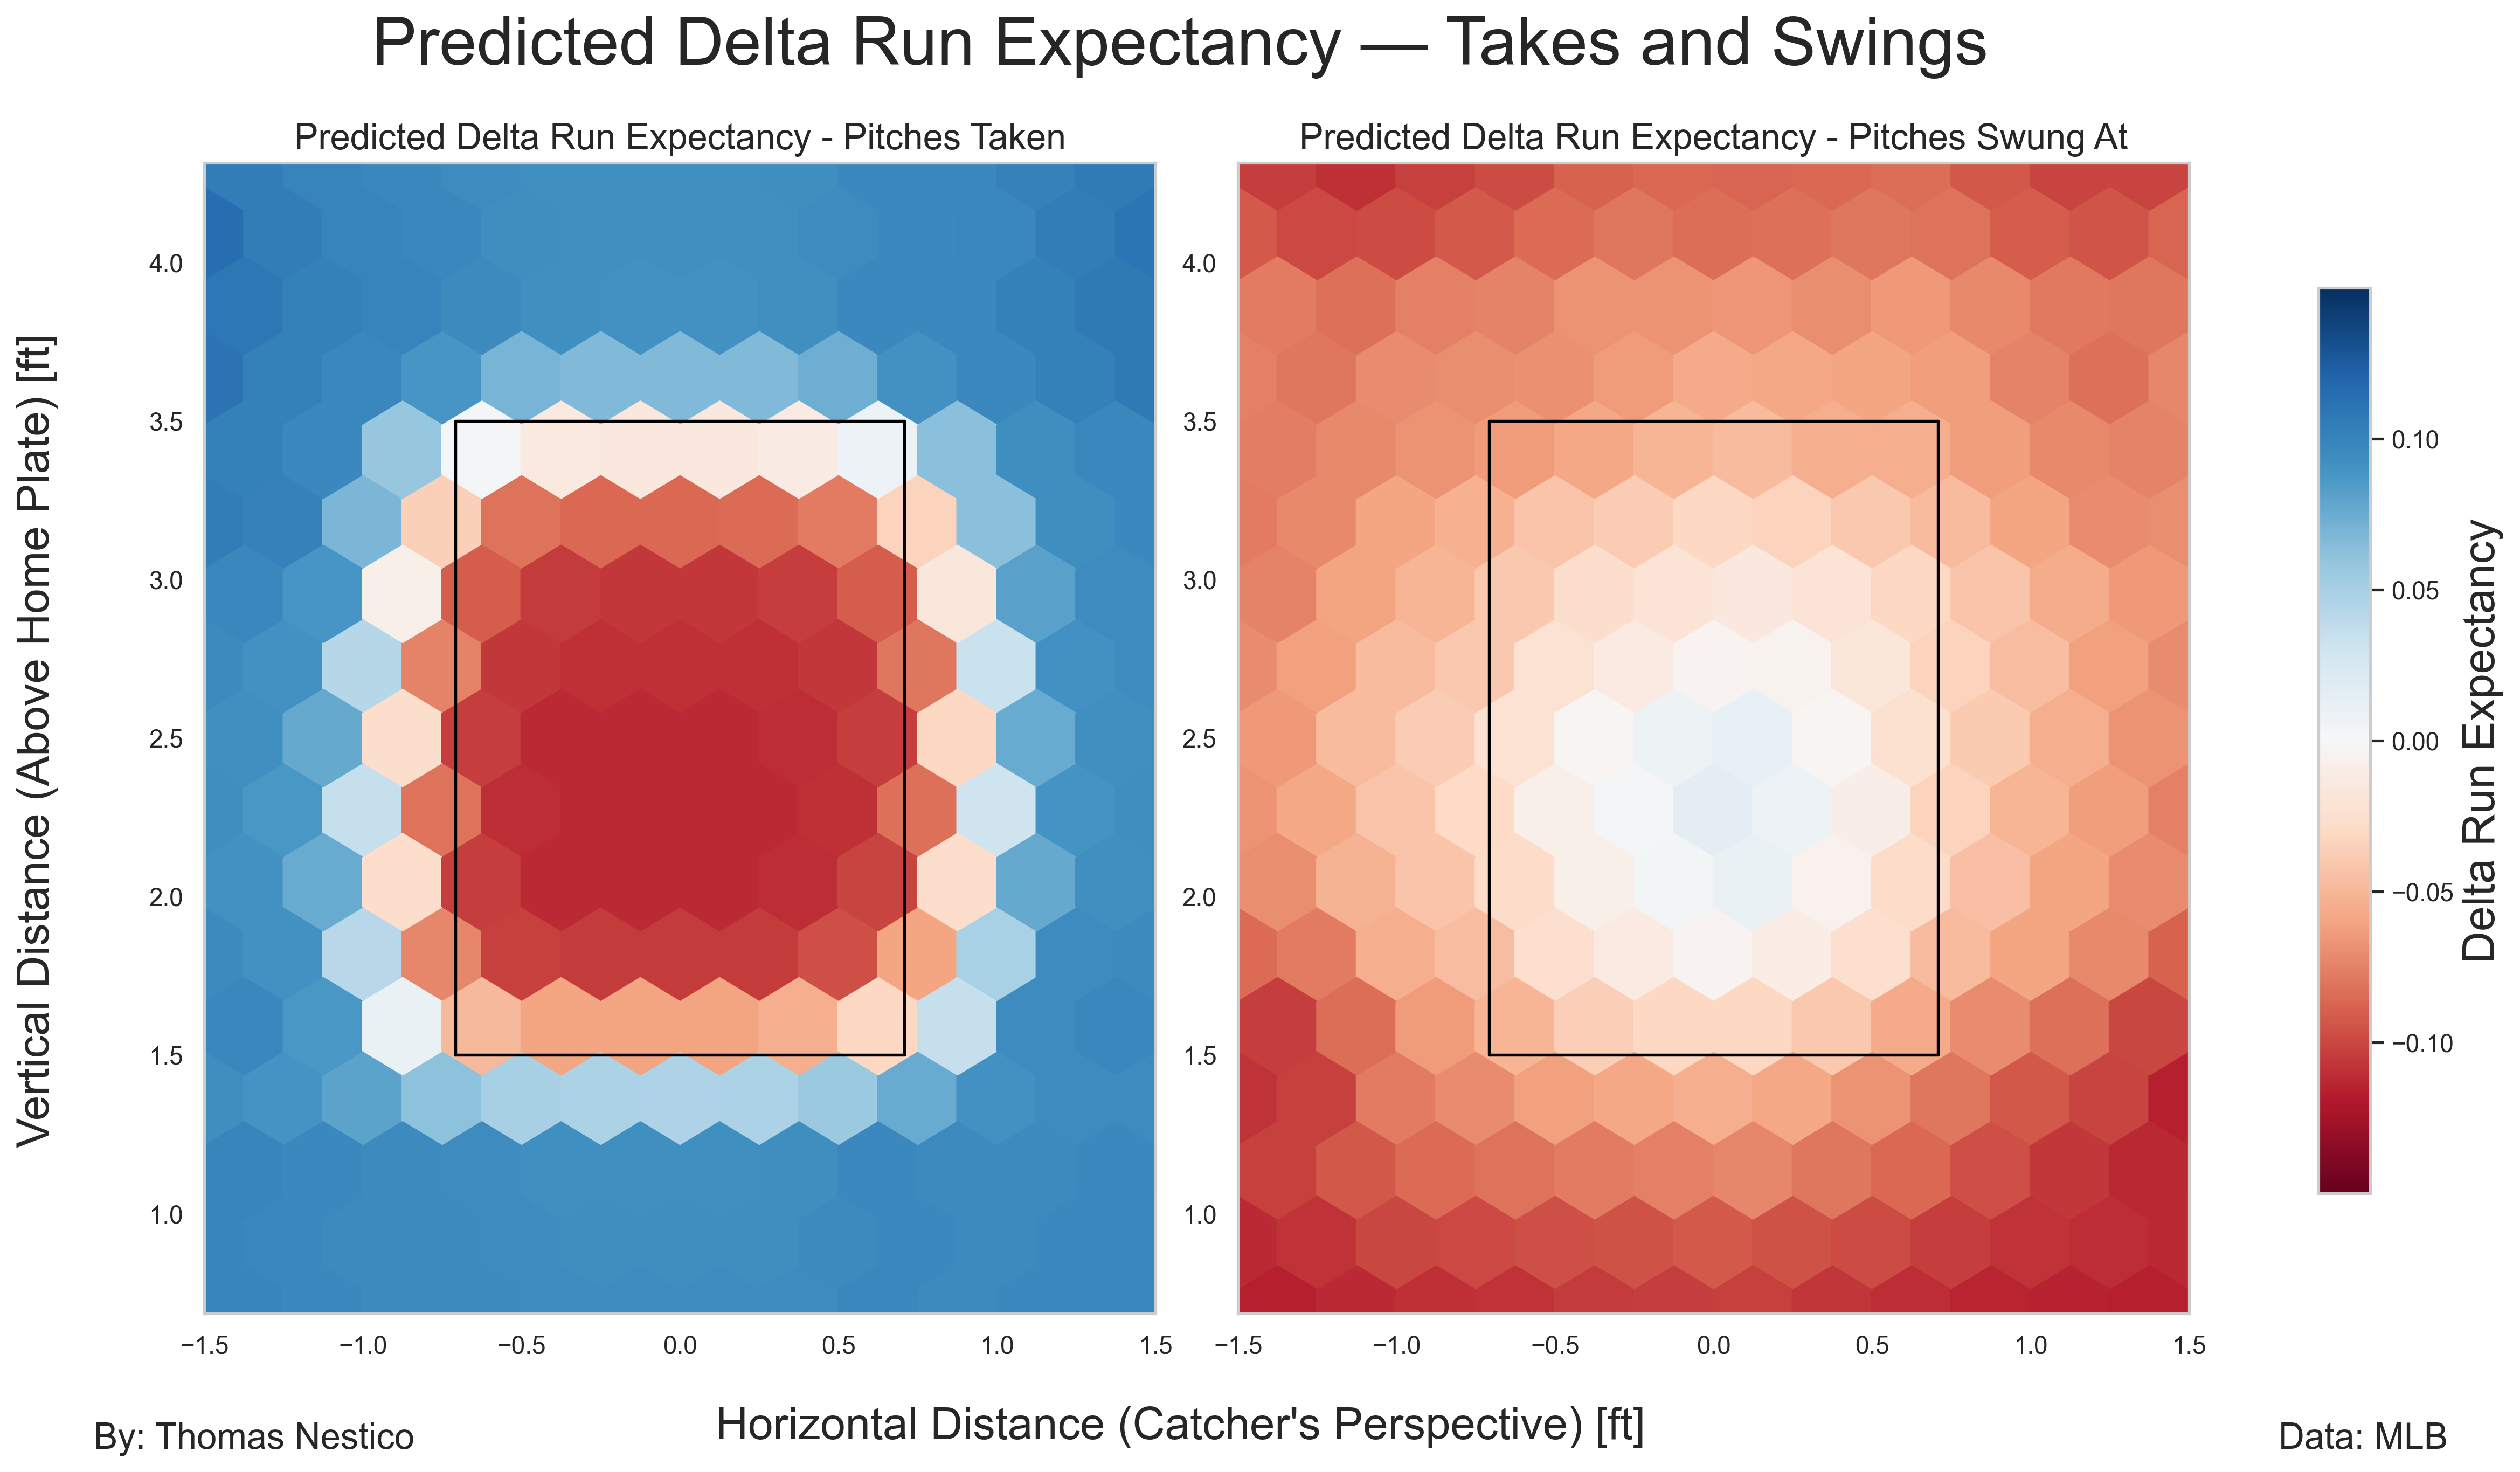

In [16]:
## Plot Predicted Run Expectancy Hex Bin Plot
loc_list_pitch = []
for s in range(0,3):
    for b in range(0,4):
        loc_cor_x_whiff = np.arange(-2.5,2.5+0.01,0.01)
        for le in range(len(loc_cor_x_whiff)):
            loc_cor_z_whiff = 0+le*0.01
            s_list = [s] * len(loc_cor_x_whiff)
            b_list = [b] * len(loc_cor_x_whiff)
            loc_list_pitch.append(pd.DataFrame(data={'plate_x':loc_cor_x_whiff,
                                                     'plate_z':loc_cor_z_whiff,
                                                     'strikes':s_list,
                                                     'balls':b_list}))

loc_table_whiff_no_swing = pd.concat(loc_list_pitch)
loc_table_whiff_swing = pd.concat(loc_list_pitch)

loc_table_whiff_no_swing['y_pred'] = model_no_swing.predict(xgb.DMatrix(loc_table_whiff_no_swing[features]))
loc_table_whiff_swing['y_pred'] = model_swing.predict(xgb.DMatrix(loc_table_whiff_swing[features]))

loc_table_whiff_no_swing['swing'] = 0
loc_table_whiff_swing['swing'] = 1

df_model_test = pd.concat([loc_table_whiff_no_swing,loc_table_whiff_swing])

## Define Extents
x_min = -2.5
x_max = 2.5
y_min = 0
y_max = 5
extent = [x_min, x_max, y_min, y_max]

# define your scale, with white at zero
vmin = -0.15
vmax = 0.15

sns.set_theme(style="whitegrid", palette="pastel")
fig, ax = plt.subplots(1, 2, figsize=(16, 8),dpi=300)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=np.array([vmin,vmax]).mean(), vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)

ax[0].hexbin(
            x=df_model_test[(df_model_test.swing == 0)]['plate_x'],
            y=df_model_test[(df_model_test.swing == 0)]['plate_z'],
            C=df_model_test[(df_model_test.swing == 0)]['y_pred'],
                    cmap='RdBu',
                    norm=norm,extent=extent,gridsize=20)

ax[1].hexbin(
            x=df_model_test[(df_model_test.swing == 1)]['plate_x'],
            y=df_model_test[(df_model_test.swing == 1)]['plate_z'],
            C=df_model_test[(df_model_test.swing == 1)]['y_pred'],
                    cmap='RdBu',
                    norm=norm,extent=extent,gridsize=20,)
ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_xlim(-1.5,1.5)
ax[1].set_xlim(-1.5,1.5)

draw_line(ax[0],catcher_p=False)
draw_line(ax[1],catcher_p=False)

ax[0].set_ylim(1,4)
ax[1].set_ylim(1,4)

ax[0].set_title('Predicted Delta Run Expectancy - Pitches Taken',fontsize=16)
ax[1].set_title('Predicted Delta Run Expectancy - Pitches Swung At',fontsize=16)
fig.tight_layout()



cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar_big = fig.colorbar(sm, cax=cbar_ax,aspect=30,shrink=0.7)
cbar_big.set_label('Delta Run Expectancy',fontsize=20)

fig.subplots_adjust(right=0.8)

fig.suptitle(x=0.41,y=1.06,t=f"Predicted Delta Run Expectancy — Takes and Swings",fontsize=30)
fig.text(0.41, -0.04, "Horizontal Distance (Catcher's Perspective) [ft]", ha='center',fontsize=20)
fig.text(-0.04, 0.5, "Vertical Distance (Above Home Plate) [ft]", va='center', rotation='vertical',fontsize=20)

fig.text(-0.01, -0.04, "By: Thomas Nestico",ha='left', va='center',fontsize=16)
fig.text(0.9, -0.04, "Data: MLB",ha='right', va='center',fontsize=16)
fig.set_facecolor('white')

In [17]:
## Create a Dataset to calculate xRV/100 Pitches
df_model_2023['pitcher_name'] = df_model_2023.pitcher.map(pitcher_dict)
df_model_2023['player_team'] = df_model_2023.batter.map(team_player_dict)
df_model_2023_group = df_model_2023.groupby(['batter','player_name','player_team']).agg(
    pitches = ('release_speed','count'),
    y_pred =  ('y_pred','mean'),
    delta_run_exp =  ('delta_run_exp','mean')
    )

## Minimum 500 pitches faced
min_pitches = 500
df_model_2023_group = df_model_2023_group[df_model_2023_group.pitches >= min_pitches]
## Calculate 20-80 Scale
df_model_2023_group['decision_value'] = zscore(df_model_2023_group['y_pred'])
df_model_2023_group['decision_value'] = (50+df_model_2023_group['decision_value']*10)


In [18]:
## Create a colour map for Highlighting players
cmap_hue = matplotlib.colors.LinearSegmentedColormap.from_list("", [colour_palette[1],'white',colour_palette[0]])
norm = plt.Normalize(20,80)

## Top 10 Decision Values
df_model_2023_group.sort_values(by=['decision_value','y_pred','pitches'],ascending=False)[['pitches','decision_value']].astype(int).head(10).style.set_caption(
    f'2023 MLB Swing Decision Leaders<br>20-80 Scale<br>Min. {min_pitches} Pitches<br>By: Thomas Nestico').background_gradient(
        cmap=cmap_hue,subset=['decision_value'],vmin=20,vmax=80).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'k'),
        ('font-size', '16px')
    ]
}])

In [19]:
## Create a Dataset for xRV/100 Pitches Swung At
df_model_2023_group_swing = df_model_2023[df_model_2023.swing==1].groupby(['batter','player_name','player_team']).agg(
    pitches = ('release_speed','count'),
    y_pred =  ('y_pred','mean'),
    delta_run_exp =  ('delta_run_exp','mean')
    )

# Select Pitches with 500 total pitches
df_model_2023_group_swing = df_model_2023_group_swing[df_model_2023_group_swing.index.get_level_values(1).isin(df_model_2023_group.index.get_level_values(1))]
## Calculate 20-80 Scale
df_model_2023_group_swing['oz_awareness'] = zscore(df_model_2023_group_swing['y_pred'])
df_model_2023_group_swing['oz_awareness'] = (((50+df_model_2023_group_swing['oz_awareness']*10)))

In [20]:
## Top 10 Out-Of-Zone Awareness
df_model_2023_group_swing.sort_values(by=['oz_awareness','y_pred','pitches'],ascending=False)[['pitches','oz_awareness']].astype(int).head(10).style.set_caption(
    f'2023 MLB Out-of-Zone Awareness<br>20-80 Scale<br>Min. {min_pitches} Pitches<br>By: Thomas Nestico').background_gradient(
        cmap=cmap_hue,subset=['oz_awareness'],vmin=20,vmax=80).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'k'),
        ('font-size', '16px')
    ]
}])

In [21]:
## Create a Dataset to calculate xRV/100 for Pitches Taken
df_model_2023_group_no_swing = df_model_2023[df_model_2023.swing==0].groupby(['batter','player_name','player_team']).agg(
    pitches = ('release_speed','count'),
    y_pred =  ('y_pred','mean'),
    delta_run_exp =  ('delta_run_exp','mean')
    )

# Select Pitches with 500 total pitches
df_model_2023_group_no_swing = df_model_2023_group_no_swing[df_model_2023_group_no_swing.index.get_level_values(1).isin(df_model_2023_group.index.get_level_values(1))]
## Calculate 20-80 Scale
df_model_2023_group_no_swing['iz_awareness'] = zscore(df_model_2023_group_no_swing['y_pred'])
df_model_2023_group_no_swing['iz_awareness'] = (((50+df_model_2023_group_no_swing['iz_awareness']*10)))

In [22]:
## Top 10 In-Zone Awareness
df_model_2023_group_no_swing.sort_values(by=['iz_awareness','y_pred','pitches'],ascending=False)[['pitches','iz_awareness']].astype(int).head(10).style.set_caption(
    f'2023 MLB Swing In-Zone Awareness<br>20-80 Scale<br>Min. {min_pitches} Pitches<br>By: Thomas Nestico').background_gradient(
        cmap=cmap_hue,subset=['iz_awareness'],vmin=20,vmax=80).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'k'),
        ('font-size', '16px')
    ]
}])

In [23]:
## Create df for plotting
# Merge Datasets
df_model_2023_group_swing_plus_no = df_model_2023_group_swing.merge(df_model_2023_group_no_swing,left_index=True,right_index=True,suffixes=['_swing','_no_swing'])
df_model_2023_group_swing_plus_no['pitches'] = df_model_2023_group_swing_plus_no.pitches_swing + df_model_2023_group_swing_plus_no.pitches_no_swing
plot_min = 500
df_model_2023_group_swing_plus_no = df_model_2023_group_swing_plus_no[df_model_2023_group_swing_plus_no.pitches >= plot_min]
# Calculate xRV/100 Pitches
df_model_2023_group_swing_plus_no['y_pred'] = (df_model_2023_group_swing_plus_no.y_pred_swing*df_model_2023_group_swing_plus_no.pitches_swing + \
                                              df_model_2023_group_swing_plus_no.y_pred_no_swing*df_model_2023_group_swing_plus_no.pitches_no_swing) / \
                                              df_model_2023_group_swing_plus_no.pitches

<ipython-input-24-ea393078ee06>:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar  = ax.figure.colorbar(sm, ax=ax,orientation='vertical',aspect=30)


Text(0.875, 0.085, 'Data: MLB')

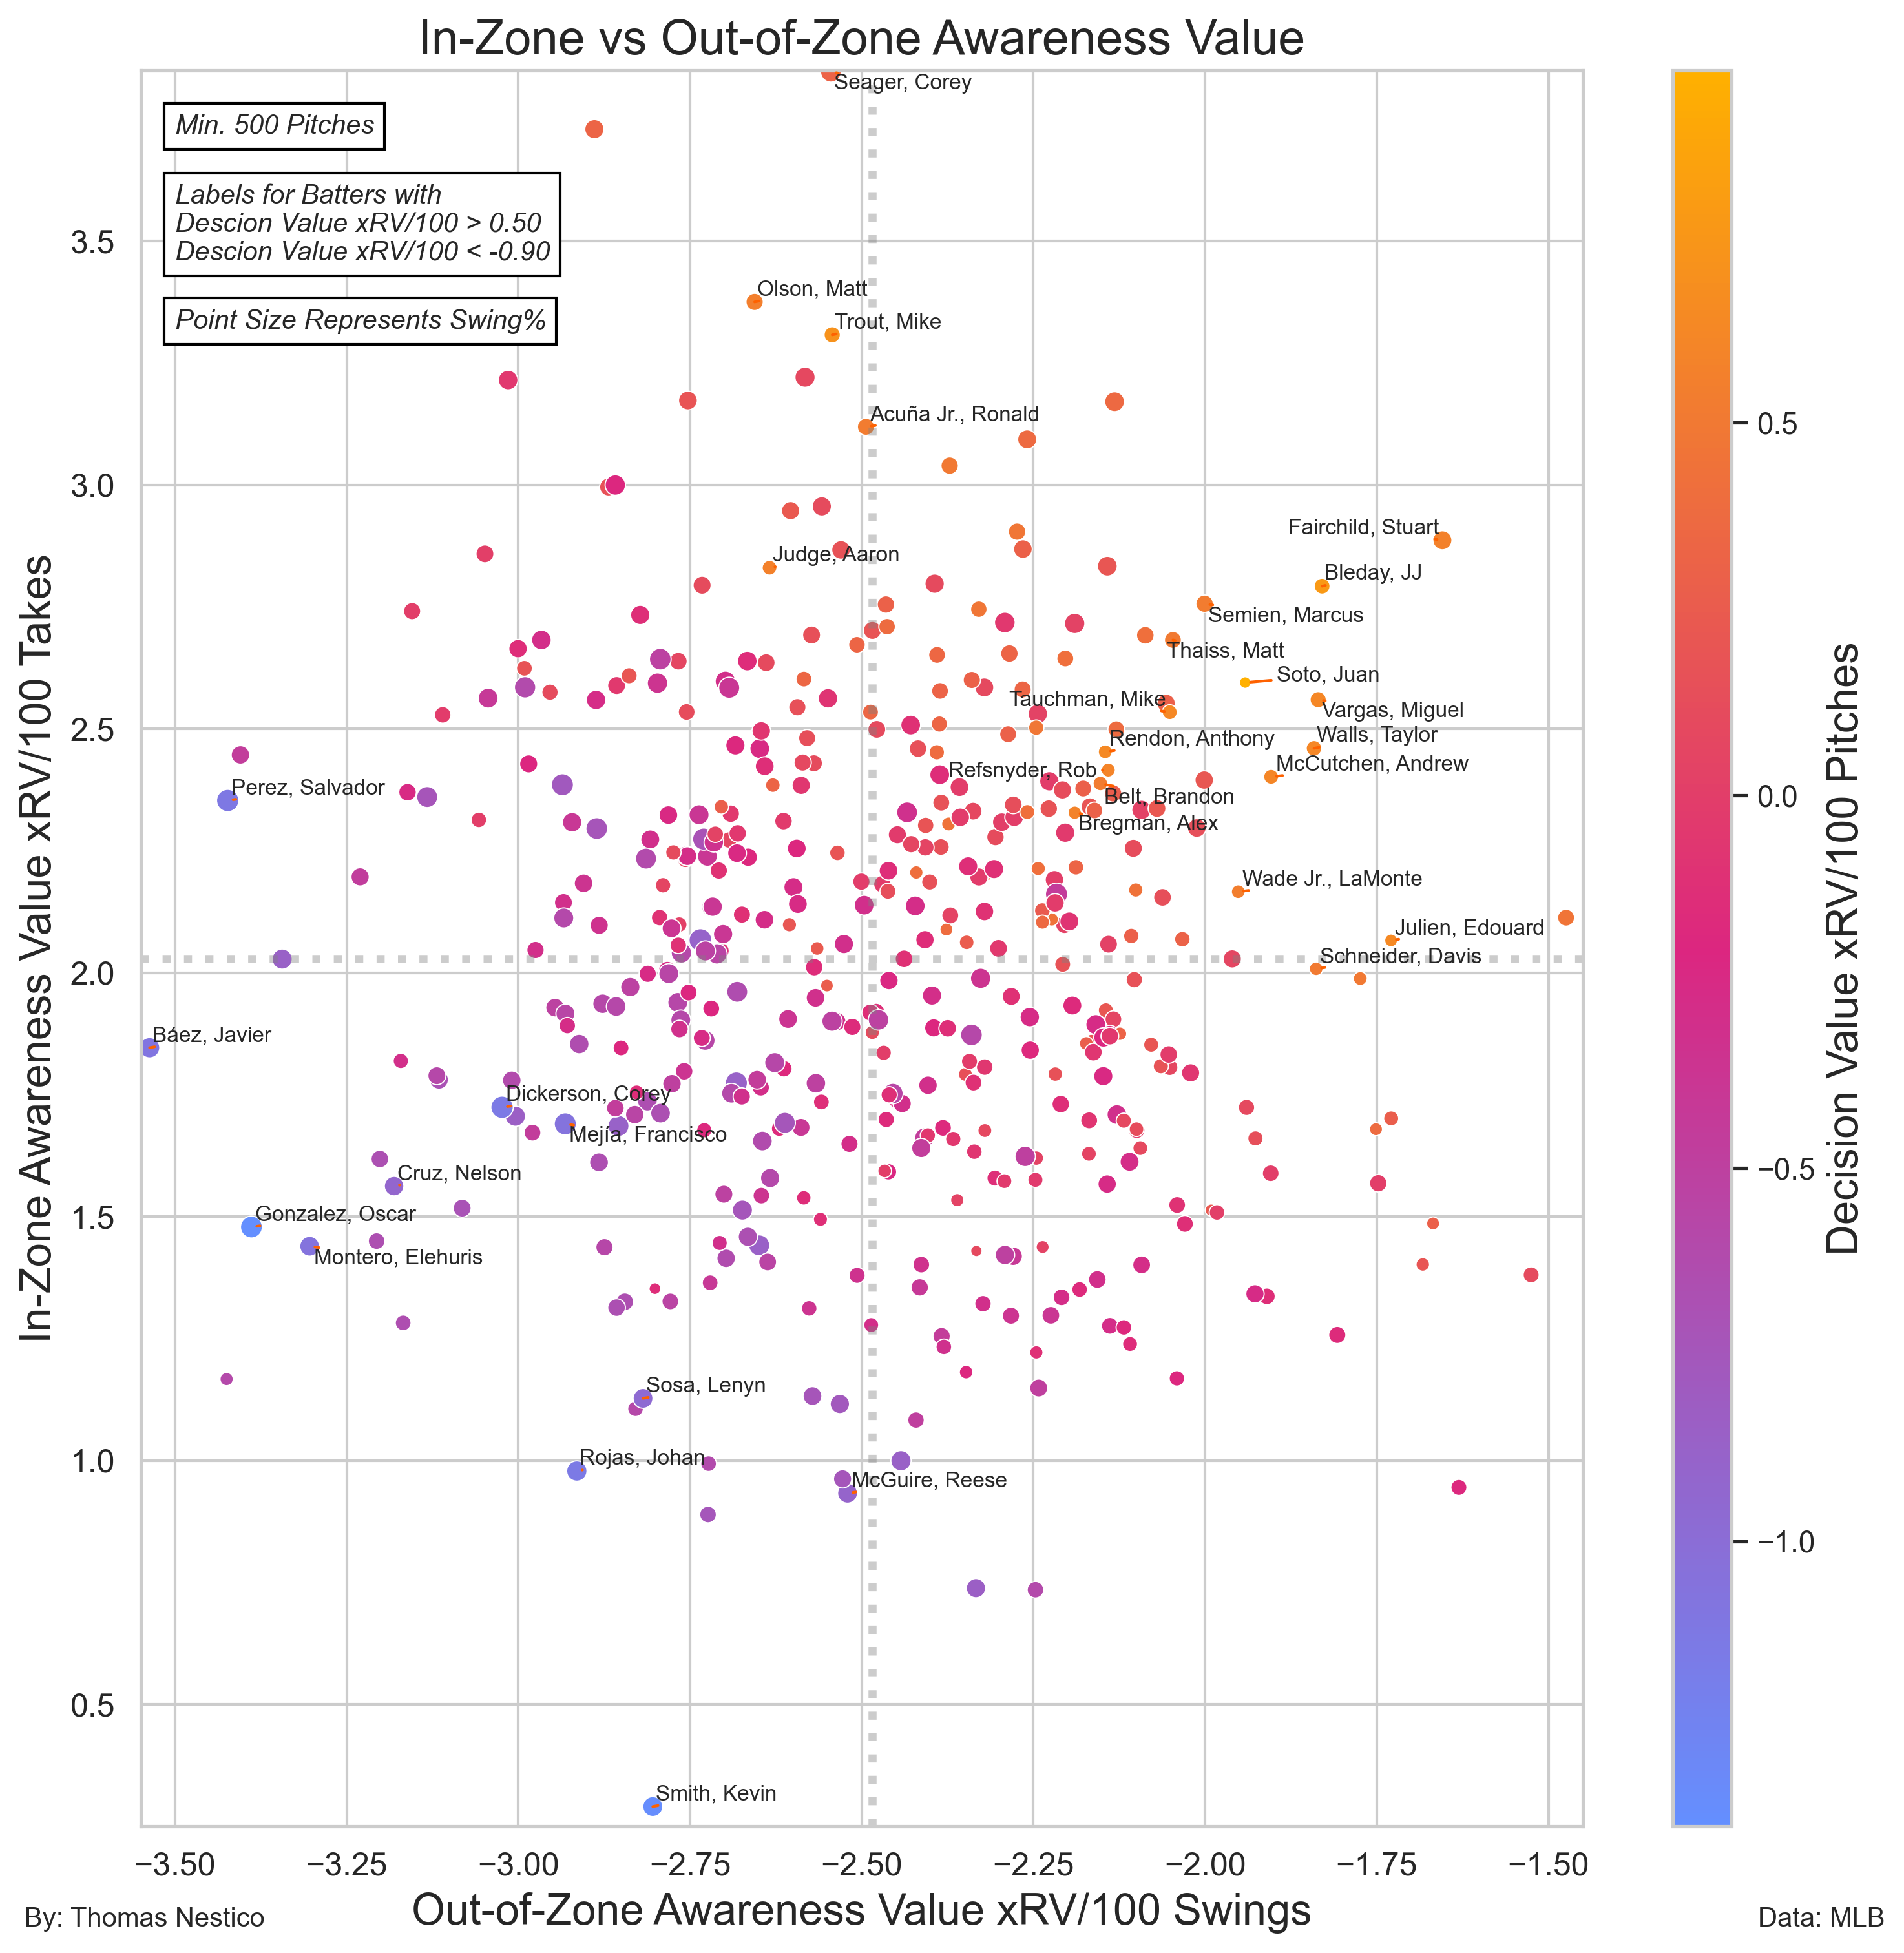

In [24]:
## Plot In-Zone vs Out-of-Zone Awareness
sns.set_theme(style="whitegrid", palette="pastel")
fig, ax = plt.subplots(1,1,figsize=(12,12),dpi=300)

cmap_hue = matplotlib.colors.LinearSegmentedColormap.from_list("", [colour_palette[1],colour_palette[3],colour_palette[0]])
norm = plt.Normalize(df_model_2023_group_swing_plus_no['y_pred'].min()*100, df_model_2023_group_swing_plus_no['y_pred'].max()*100)

sns.scatterplot(
                x=df_model_2023_group_swing_plus_no['y_pred_swing']*100,
                y=df_model_2023_group_swing_plus_no['y_pred_no_swing']*100,
                hue=df_model_2023_group_swing_plus_no['y_pred']*100,
                size=df_model_2023_group_swing_plus_no['pitches_swing']/df_model_2023_group_swing_plus_no['pitches'],
                palette=cmap_hue)

sm = plt.cm.ScalarMappable(cmap=cmap_hue, norm=norm)
cbar  = ax.figure.colorbar(sm, ax=ax,orientation='vertical',aspect=30)
cbar.set_label('Decision Value xRV/100 Pitches',fontsize=16)

ax.hlines(xmin=(math.floor((df_model_2023_group_swing_plus_no['y_pred_swing'].min()*100*100-0.01)/5))*5/100,
            xmax= (math.ceil((df_model_2023_group_swing_plus_no['y_pred_swing'].max()**100100+0.01)/5))*5/100,
            y=df_model_2023_group_swing_plus_no['y_pred_no_swing'].mean()*100,color='gray',linewidth=3,linestyle='dotted',alpha=0.4)

ax.vlines(ymin=(math.floor((df_model_2023_group_swing_plus_no['y_pred_no_swing'].min()*100*100-0.01)/5))*5/100,
            ymax= (math.ceil((df_model_2023_group_swing_plus_no['y_pred_no_swing'].max()*100*100+0.01)/5))*5/100,
            x=df_model_2023_group_swing_plus_no['y_pred_swing'].mean()*100,color='gray',linewidth=3,linestyle='dotted',alpha=0.4)



ax.set_xlim((math.floor((df_model_2023_group_swing_plus_no['y_pred_swing'].min()*100*100)/5))*5/100,
            (math.ceil((df_model_2023_group_swing_plus_no['y_pred_swing'].max()*100*100)/5))*5/100)


ax.set_ylim((math.floor((df_model_2023_group_swing_plus_no['y_pred_no_swing'].min()*100*100)/5))*5/100,
            (math.ceil((df_model_2023_group_swing_plus_no['y_pred_no_swing'].max()*100*100)/5))*5/100)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Out-of-Zone Awareness Value xRV/100 Swings',fontsize=16)
ax.set_ylabel('In-Zone Awareness Value xRV/100 Takes',fontsize=16)
ax.get_legend().remove()

ax.set_title('In-Zone vs Out-of-Zone Awareness Value',fontsize=18)

ts=[]


thresh = 0.50
thresh_2 = -0.9
for i in range(len(df_model_2023_group_swing_plus_no)):
        if (df_model_2023_group_swing_plus_no['y_pred'].values[i]*100) >= thresh or \
           (df_model_2023_group_swing_plus_no['y_pred'].values[i]*100) <= thresh_2 or \
           (df_model_2023_group_swing_plus_no.index.get_level_values(1).values[i]) == 'Soto, Juan' or \
           (df_model_2023_group_swing_plus_no.index.get_level_values(1).values[i]) == 'Seager, Corey':
              ts.append(ax.text(x=df_model_2023_group_swing_plus_no['y_pred_swing'].values[i]*100,
                              y=df_model_2023_group_swing_plus_no['y_pred_no_swing'].values[i]*100,
                              s=df_model_2023_group_swing_plus_no.index.get_level_values(1).values[i],
                              fontsize=8))


ax.text(x=-3.5,y=3.71,s=f'Min. {plot_min} Pitches',fontsize='10',fontstyle='oblique',va='bottom',
        bbox=dict(facecolor='white', edgecolor='black'))
ax.text(x=-3.5,y=3.45,s=f'Labels for Batters with\nDescion Value xRV/100 > {thresh:.2f}\nDescion Value xRV/100 < {thresh_2:.2f}',fontsize='10',fontstyle='oblique',va='bottom',
        bbox=dict(facecolor='white', edgecolor='black'))
ax.text(x=-3.5,y=3.31,s=f'Point Size Represents Swing%',fontsize='10',fontstyle='oblique',va='bottom',
        bbox=dict(facecolor='white', edgecolor='black'))

adjust_text(ts,
            arrowprops=dict(arrowstyle="-", color=colour_palette[4], lw=1),ax=ax)

fig.text(0.075, 0.085, "By: Thomas Nestico",ha='left', va='center',fontsize=10)
fig.text(0.875, 0.085, "Data: MLB",ha='right', va='center',fontsize=10)

Text(0.925, 0.085, 'Data: MLB')

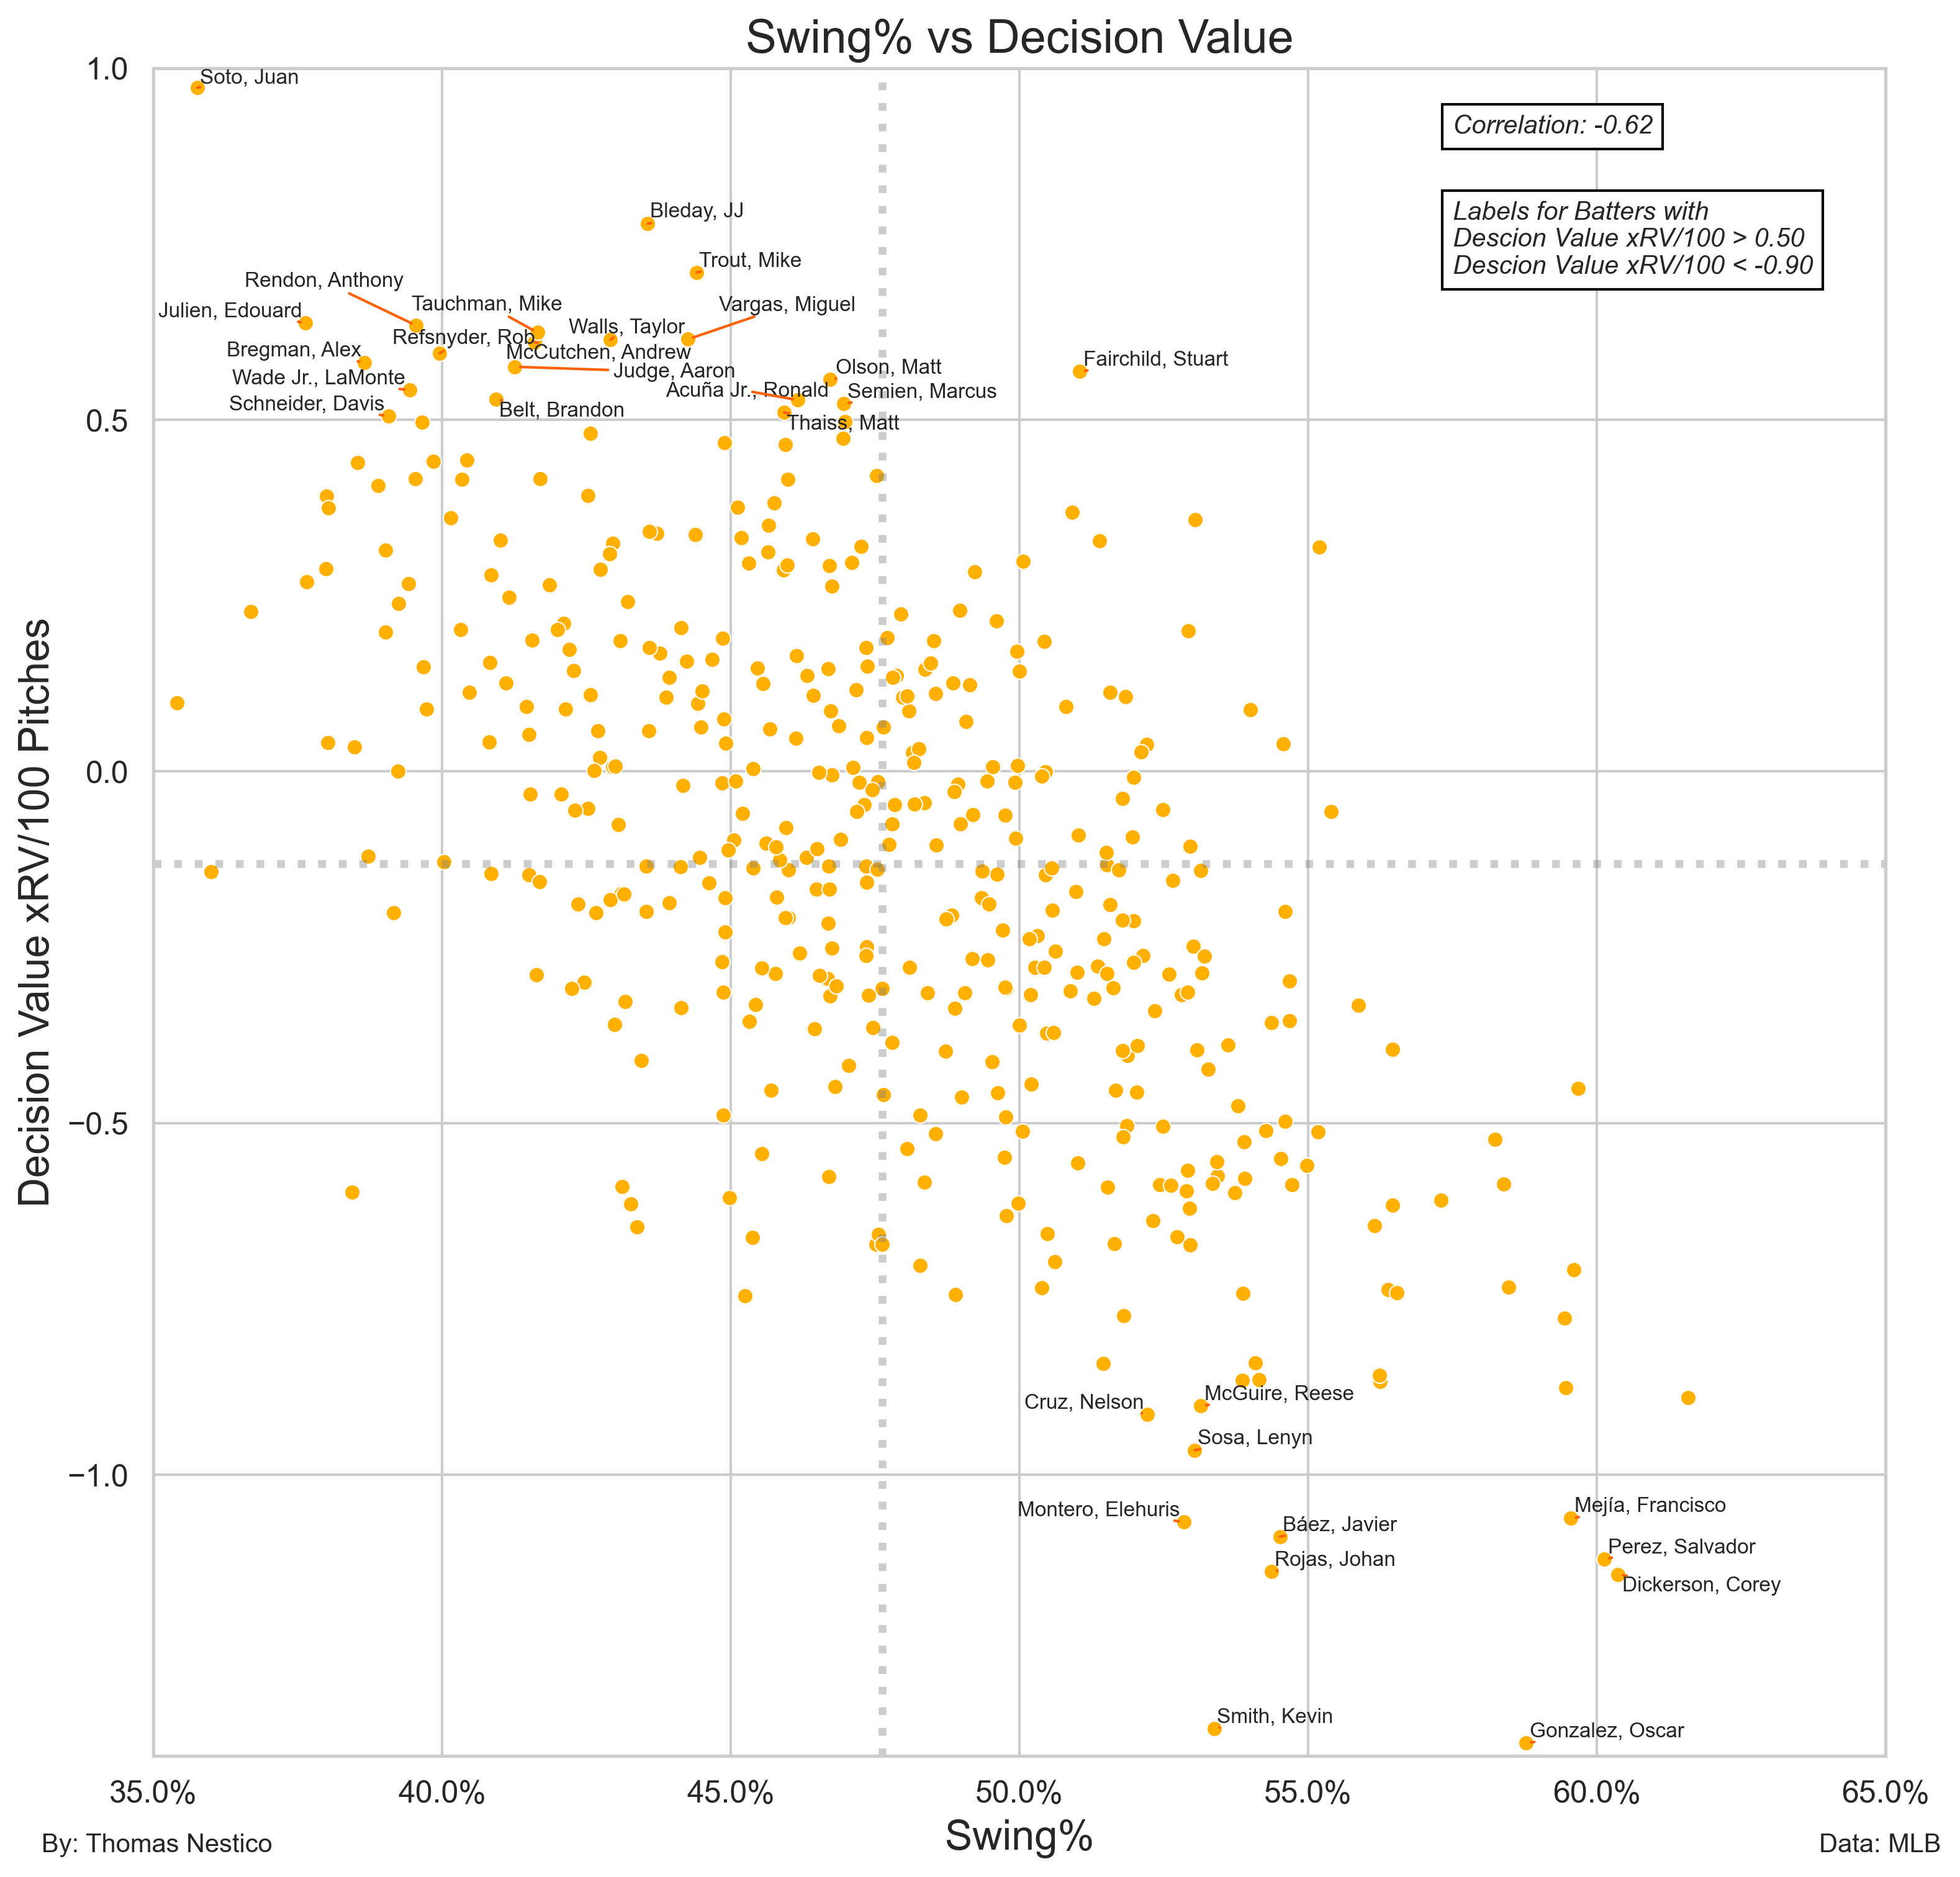

In [25]:
## Plot xRV/100 Pitches vs Swing%
sns.set_theme(style="whitegrid", palette="pastel")
fig, ax = plt.subplots(1,1,figsize=(12,12),dpi=300)

cmap_hue = matplotlib.colors.LinearSegmentedColormap.from_list("", [colour_palette[1],colour_palette[3],colour_palette[0]])
norm = plt.Normalize(df_model_2023_group_swing_plus_no['y_pred'].min()*100, df_model_2023_group_swing_plus_no['y_pred'].max()*100)

sns.scatterplot(
                x=df_model_2023_group_swing_plus_no['pitches_swing']/df_model_2023_group_swing_plus_no['pitches'],
                y=df_model_2023_group_swing_plus_no['y_pred']*100,
                color=colour_palette[0])

ax.vlines(ymin=(math.floor((df_model_2023_group_swing_plus_no['y_pred'].min()*100*100-0.01)/5))*5/100,
            ymax= (math.ceil((df_model_2023_group_swing_plus_no['y_pred'].max()*100*100+0.01)/5))*5/100,
            x=(df_model_2023_group_swing_plus_no['pitches_swing']/df_model_2023_group_swing_plus_no['pitches']).mean(),color='gray',linewidth=3,linestyle='dotted',alpha=0.4)

ax.hlines(xmin=(math.floor(((df_model_2023_group_swing_plus_no['pitches_swing']/df_model_2023_group_swing_plus_no['pitches']).min()*100-0.01)/5))*5/100,
            xmax= (math.ceil(((df_model_2023_group_swing_plus_no['pitches_swing']/df_model_2023_group_swing_plus_no['pitches']).max()*100+0.01)/5))*5/100,
            y=df_model_2023_group_swing_plus_no['y_pred'].mean()*100,color='gray',linewidth=3,linestyle='dotted',alpha=0.4)



ax.set_xlim((math.floor(((df_model_2023_group_swing_plus_no['pitches_swing']/df_model_2023_group_swing_plus_no['pitches']).min()*100)/5))*5/100,
            (math.ceil(((df_model_2023_group_swing_plus_no['pitches_swing']/df_model_2023_group_swing_plus_no['pitches']).max()*100)/5))*5/100)


ax.set_ylim((math.floor((df_model_2023_group_swing_plus_no['y_pred'].min()*100*100)/5))*5/100,
            (math.ceil((df_model_2023_group_swing_plus_no['y_pred'].max()*100*100)/5))*5/100)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Swing%',fontsize=16)
ax.set_ylabel('Decision Value xRV/100 Pitches',fontsize=16)
#ax.get_legend().remove()

ax.set_title('Swing% vs Decision Value',fontsize=18)

ts=[]

corr_value = np.corrcoef(df_model_2023_group_swing_plus_no['pitches_swing']/df_model_2023_group_swing_plus_no['pitches'],
        df_model_2023_group_swing_plus_no['y_pred'])[0][1]




thresh = 0.5
thresh_2 = -0.9
for i in range(len(df_model_2023_group_swing_plus_no)):
        if (df_model_2023_group_swing_plus_no['y_pred'].values[i]*100) >= thresh or \
           (df_model_2023_group_swing_plus_no['y_pred'].values[i]*100) <= thresh_2:
              ts.append(ax.text(x=(df_model_2023_group_swing_plus_no['pitches_swing']/df_model_2023_group_swing_plus_no['pitches']).values[i],
                              y=df_model_2023_group_swing_plus_no['y_pred'].values[i]*100,
                              s=df_model_2023_group_swing_plus_no.index.get_level_values(1).values[i],
                              fontsize=8))


# ax.text(x=-3.5,y=3.71,s=f'Min. {plot_min} Pitches',fontsize='10',fontstyle='oblique',va='bottom',
#         bbox=dict(facecolor='white', edgecolor='black'))
# ax.text(x=-3.5,y=3.45,s=f'Labels for Batters with\nDescion Value xRV/100 > {thresh:.2f}\nDescion Value xRV/100 < {thresh_2:.2f}',fontsize='10',fontstyle='oblique',va='bottom',
#         bbox=dict(facecolor='white', edgecolor='black'))
# ax.text(x=-3.5,y=3.31,s=f'Point Size Represents Swing%',fontsize='10',fontstyle='oblique',va='bottom',
#         bbox=dict(facecolor='white', edgecolor='black'))
ax.text(x=0.575,y=0.9,s=f'Correlation: {corr_value:.2}',fontsize='10',fontstyle='oblique',va='bottom',
        bbox=dict(facecolor='white', edgecolor='black'))

ax.text(x=0.575,y=0.7,s=f'Labels for Batters with\nDescion Value xRV/100 > {thresh:.2f}\nDescion Value xRV/100 < {thresh_2:.2f}',fontsize='10',fontstyle='oblique',va='bottom',
        bbox=dict(facecolor='white', edgecolor='black'))


adjust_text(ts,
            arrowprops=dict(arrowstyle="-", color=colour_palette[4], lw=1),ax=ax)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
fig.text(0.075, 0.085, "By: Thomas Nestico",ha='left', va='center',fontsize=10)
fig.text(0.925, 0.085, "Data: MLB",ha='right', va='center',fontsize=10)